# Foundations of Machine Learning Frameworks - CSCN8010

## Practical Lab 1: 
### Streaming Data for Predictive Maintenance with Linear Regression-Based Alerts



This notebook:
1. Fits a linear regression baseline of Axis #1 vs Time using the training file.
2. Records slope and intercept.
3. Predicts on the test file and computes positive residuals (observed − predicted).
4. Derives data-driven thresholds (quartile-based and std-based) from training residuals.
5. Estimates a persistence time T using irregular timestamps and a 2-second grace rule.
6. Detects sustained Alerts/Errors on the test set.
7. Plots regression fits, residual distributions, and overlays event markers with durations.
8. Logs events to CSV (event_id, level, start_time, end_time, duration_sec, peak_residual, mean_residual, area_above_baseline).

## Install dependencies

In [ ]:
%pip install -r requirements.txt

## Imports and file paths

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# Load the .env file
load_dotenv()

DB_CONNSTRING = os.getenv('DB_CONNSTRING')


# The db connection string is inluded in the submission PDF
engine = create_engine(DB_CONNSTRING)


# File paths
TEST_PATH  = 'data/RMBR4-2_export_test.csv'

# Output paths
EVENTS_CSV = 'logs/axis_events.csv'

### Load Training Data

Read all the training data from DB

In [3]:
df_train = pd.read_sql("SELECT * FROM rmbr4_2_export_train", engine)
# Rename DataFrame columns to match original CSV headers
df_train = df_train.rename(columns={
    "trait": "Trait",
    "axis_1": "Axis #1",
    "axis_2": "Axis #2",
    "axis_3": "Axis #3",
    "axis_4": "Axis #4",
    "axis_5": "Axis #5",
    "axis_6": "Axis #6",
    "axis_7": "Axis #7",
    "axis_8": "Axis #8",
    "axis_9": "Axis #9",
    "axis_10": "Axis #10",
    "axis_11": "Axis #11",
    "axis_12": "Axis #12",
    "axis_13": "Axis #13",
    "axis_14": "Axis #14",
    "time": "Time"
})

df_train.head()


Trait  Axis #1  Axis #2  Axis #3  Axis #4  Axis #5  Axis #6  Axis #7  \
0  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   Axis #8 Axis #9 Axis #10 Axis #11 Axis #12 Axis #13 Axis #14  \
0      0.0    None     None     None     None     None     None   
1      0.0    None     None     None     None     None     None   
2      0.0    None     None     None     None     None     None   
3      0.0    None     None     None     None     None     None   
4      0.0    None     None     None     None     None     None   

                              Time  
0 2022-10-17 12:18:23.660000+00:00  
1 2022-10-17 12:18:25.472000+00:00  
2 2022-10-17 12:18:27.348000+00:00  
3 2022-10-17 12:18:29.222000+00:00  
4 2022-10-17 12:18:31.117000+00:00

Read the Test data from a CSV file

In [4]:
df_test = pd.read_csv(TEST_PATH)
df_test.head()

Trait  Axis #1  Axis #2  Axis #3  Axis #4  Axis #5  Axis #6  Axis #7  \
0  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   Axis #8  Axis #9  Axis #10  Axis #11  Axis #12  Axis #13  Axis #14  \
0      0.0      NaN       NaN       NaN       NaN       NaN       NaN   
1      0.0      NaN       NaN       NaN       NaN       NaN       NaN   
2      0.0      NaN       NaN       NaN       NaN       NaN       NaN   
3      0.0      NaN       NaN       NaN       NaN       NaN       NaN   
4      0.0      NaN       NaN       NaN       NaN       NaN       NaN   

                       Time  
0  2022-10-17T12:18:23.660Z  
1  2022-10-17T12:18:25.472Z  
2  2022-10-17T12:18:27.348Z  
3  2022-10-17T12:18:29.222Z  
4  2022-10-17T12:18:31.117Z

In [5]:
# Load and preprocess Axis data
def load_axis_with_time(df, axis_col):

    # Parse time
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)

    # Drop rows with invalid time
    df = df.dropna(subset=['Time'])

    # Keep Axis # and Time
    df[axis_col] = pd.to_numeric(df[axis_col], errors='coerce')

    # Drop rows with missing axis data
    df = df.dropna(subset=[axis_col])

    # Sort by time
    df = df.sort_values('Time').reset_index(drop=True)

    # Numeric seconds for regression
    df['t_sec'] = (df['Time'].astype('int64') // 10**9).astype(float)
    
    return df[['Time', 't_sec', axis_col]]

## Load data and parse timestamps
We use the ISO 8601 Time column with Z suffix and convert it to seconds since epoch for regression.

In [6]:
train_axis1_with_time_df = load_axis_with_time(df_train, 'Axis #1')
test_axis1_with_time_df = load_axis_with_time(df_test, 'Axis #1')


print('Train Axis 1 rows:', len(train_axis1_with_time_df), ' Test rows:', len(test_axis1_with_time_df), '\n')
print('Train Axis 1 time range:', train_axis1_with_time_df['Time'].min(), '→', train_axis1_with_time_df['Time'].max())
print('Test Axis 1 time range:', test_axis1_with_time_df['Time'].min(),  '→', test_axis1_with_time_df['Time'].max())

Train Axis 1 rows: 39672  Test rows: 39672 

Train Axis 1 time range: 2022-10-17 12:18:23.660000+00:00 → 2022-10-18 10:44:58.628000+00:00
Test Axis 1 time range: 2022-10-17 12:18:23.660000+00:00 → 2022-10-18 10:44:58.628000+00:00


We have added a **t_sec** column to work the numeric representation of Time

## Fit linear regression baseline on training set
Predict Axis #1 from timestamp in seconds. Record slope and intercept.

In [7]:
train = train_axis1_with_time_df.copy()
test  = test_axis1_with_time_df.copy()

X_train = train[['t_sec']].values
y_train = train['Axis #1'].values

model = LinearRegression()
model.fit(X_train, y_train)

slope = float(model.coef_[0])
intercept = float(model.intercept_)
print('Slope:', slope)
print('Intercept:', intercept)

Slope: -1.1768231466761014e-07
Intercept: 196.79034998875943


## Predictions and residuals on train and test
Residuals are observed minus predicted. We will focus on positive residuals for alerts/errors.

In [8]:
# Train residuals (for threshold derivation)
train['y_pred'] = model.predict(train[['t_sec']].values)
train['residual'] = train['Axis #1'] - train['y_pred']
train_pos = train[train['residual'] > 0].copy()

# Test residuals (for detection)
test['y_pred'] = model.predict(test[['t_sec']].values)
test['residual'] = test['Axis #1'] - test['y_pred']
test_pos = test[test['residual'] > 0].copy()

print('Train positive residuals:', len(train_pos), 'of', len(train))
print('Test  positive residuals:', len(test_pos),  'of', len(test))

Train positive residuals: 6658 of 39672
Test  positive residuals: 13475 of 39672


## Derive thresholds MinC and MaxC from training residuals
We compute both quartile-based and std-based thresholds using **positive** training residuals. Then we pick the quartile-based pair by default.

In [9]:
def threshold_quartile(residuals):
    q1 = np.percentile(residuals, 25)
    q3 = np.percentile(residuals, 75)
    iqr = q3 - q1
    minC = q3 + 1.5 * iqr
    maxC = q3 + 3.0 * iqr
    return minC, maxC, (q1, q3, iqr)

def threshold_std(residuals):
    m = residuals.mean()
    s = residuals.std(ddof=1) if len(residuals) > 1 else 0.0
    minC = m + 2.0 * s
    maxC = m + 3.0 * s
    return minC, maxC, (m, s)

train_pos_vals = train_pos['residual'].values

if len(train_pos_vals) == 0:
    # Fallback if no positive residuals in training
    minC_q = maxC_q = 0.0
    q_stats = (0, 0, 0)
    minC_s = maxC_s = 0.0
    s_stats = (0, 0)
else:
    minC_q, maxC_q, q_stats = threshold_quartile(train_pos_vals)
    minC_s, maxC_s, s_stats = threshold_std(train_pos_vals)

print('Quartile-based thresholds:')
print('  MinC_q =', minC_q, ' MaxC_q =', maxC_q, ' [q1, q3, IQR]=', q_stats)
print('Std-based thresholds:')
print('  MinC_s =', minC_s, ' MaxC_s =', maxC_s, ' [mean, std]=', s_stats)

# Choose which thresholds to use for detection
MinC = float(minC_q)
MaxC = float(maxC_q)
print('\nUsing quartile-based thresholds by default: MinC=', MinC, ' MaxC=', MaxC)

Quartile-based thresholds:
  MinC_q = 9.347181099296069  MaxC_q = 14.54470429657973  [q1, q3, IQR]= (np.float64(0.6846424371566362), np.float64(4.14965790201241), np.float64(3.4650154648557736))
Std-based thresholds:
  MinC_s = 10.992042524218979  MaxC_s = 14.854307686681105  [mean, std]= (np.float64(3.267512199294727), np.float64(3.8622651624621263))

Using quartile-based thresholds by default: MinC= 9.347181099296069  MaxC= 14.54470429657973


## Estimate persistence time T from training residuals with 2s grace
We find runs of positive residuals above MinC on training data, allow a 2-second grace gap between above-threshold points, and set T to the 95th percentile of those run durations, but no less than 2 seconds.

In [10]:
def estimate_median_dt(times):
    t = times.astype('int64') // 10**9
    if len(t) < 2:
        return 0.0
    diffs = np.diff(t)
    return float(np.median(diffs))

def detect_runs_above_threshold(df, threshold, grace_sec=2.0):
    # df must have columns: Time (datetime), residual (float)
    pos = df[df['residual'] > threshold].copy()
    if pos.empty:
        return []
    tsec = (pos['Time'].astype('int64') // 10**9).values.astype(float)
    idx  = pos.index.values

    # Allow a gap up to median_dt + grace_sec between consecutive above-threshold points
    median_dt = estimate_median_dt(pos['Time'])
    allowed_gap = median_dt + grace_sec

    runs = []
    start = 0
    for i in range(1, len(pos)):
        gap = tsec[i] - tsec[i-1]
        if gap > allowed_gap:
            runs.append({
                'start_idx': int(idx[start]),
                'end_idx': int(idx[i-1]),
                'start_time': pd.to_datetime(pos['Time'].iloc[start]),
                'end_time': pd.to_datetime(pos['Time'].iloc[i-1]),
            })
            start = i
    runs.append({
        'start_idx': int(idx[start]),
        'end_idx': int(idx[len(pos)-1]),
        'start_time': pd.to_datetime(pos['Time'].iloc[start]),
        'end_time': pd.to_datetime(pos['Time'].iloc[len(pos)-1]),
    })

    for r in runs:
        r['duration_sec'] = (r['end_time'] - r['start_time']).total_seconds()
    return runs

train_runs = detect_runs_above_threshold(train, MinC, grace_sec=2.0)
durations = [r['duration_sec'] for r in train_runs]
if len(durations) == 0:
    T = 2.0
else:
    T = max(2.0, float(np.percentile(durations, 95)))
    

print('Estimated T (sec):', T)

Estimated T (sec): 164.59569999999997


In [11]:
# Median dt from ALL training timestamps (sorted)
t_train = (train['Time'].astype('int64') // 10**9).values.astype(float)
dt_all = np.diff(t_train) if len(t_train) >= 2 else np.array([2.0])
median_dt = float(np.median(dt_all)) if len(dt_all) else 2.0

# Choose how many consecutive samples you require above threshold
N = 2  # we will try 2 first. we can raise to 5–10 for stricter persistence

# Final persistence time
T = max(2.0, N * median_dt)
print("Estimated T (sec):", T)


Estimated T (sec): 4.0


## Detect sustained Alerts and Errors on the test set
We apply the same run-detection logic to test residuals using MinC and MaxC with a 2-second grace. An event is valid if duration ≥ T seconds.

In [12]:
def summarize_run(df, run, level):
    seg = df.loc[run['start_idx']:run['end_idx']]
    seg = seg[seg['residual'] > 0]
    print('seg', seg)
    duration = (run['end_time'] - run['start_time']).total_seconds()
    peak_res = float(seg['residual'].max()) if not seg.empty else 0.0
    mean_res = float(seg['residual'].mean()) if not seg.empty else 0.0
    if len(seg) >= 2:
        tsec = (seg['Time'].astype('int64') // 10**9).values.astype(float)
        rvals = seg['residual'].values
        area = float(np.trapz(rvals, tsec))
    else:
        area = 0.0
    return {
        'level': level,
        'start_time': run['start_time'],
        'end_time': run['end_time'],
        'duration_sec': duration,
        'peak_residual': peak_res,
        'mean_residual': mean_res,
        'area_above_baseline': area,
    }

def detect_events(df, minC, maxC, T_sec, grace_sec=2.0):
    alerts = []
    errors = []
    min_runs = detect_runs_above_threshold(df, minC, grace_sec=grace_sec)
    max_runs = detect_runs_above_threshold(df, maxC, grace_sec=grace_sec)
    for r in min_runs:
        if r['duration_sec'] >= T_sec:
            alerts.append(summarize_run(df, r, 'ALERT'))
    for r in max_runs:
        if r['duration_sec'] >= T_sec:
            errors.append(summarize_run(df, r, 'ERROR'))
    for i, e in enumerate(alerts, start=1):
        e['event_id'] = f'A{i:04d}'
    for i, e in enumerate(errors, start=1):
        e['event_id'] = f'E{i:04d}'
    return alerts, errors

alerts, errors = detect_events(test, MinC, MaxC, T, grace_sec=2.0)
events_df = pd.DataFrame(alerts + errors, columns=[
    'event_id','level','start_time','end_time','duration_sec','peak_residual','mean_residual','area_above_baseline'
])


# prepend a column to events_df
events_df.insert(0, 'axis', 'Axis #1')

print('Detected events:')
display(events_df.head(20))
print('Total Alerts:', len(alerts), ' Total Errors:', len(errors))

seg                                  Time         t_sec    Axis #1    y_pred  \
36   2022-10-17 12:19:35.905000+00:00  1.666009e+09  21.972193  0.730534   
37   2022-10-17 12:19:37.918000+00:00  1.666009e+09   1.918274  0.730534   
38   2022-10-17 12:19:39.841000+00:00  1.666009e+09   1.858264  0.730534   
39   2022-10-17 12:19:41.758000+00:00  1.666009e+09   1.763715  0.730533   
40   2022-10-17 12:19:43.676000+00:00  1.666009e+09   1.671025  0.730533   
...                               ...           ...        ...       ...   
1425 2022-10-17 13:18:29.344000+00:00  1.666013e+09   2.112649  0.730118   
1426 2022-10-17 13:18:31.212000+00:00  1.666013e+09   2.073690  0.730118   
1427 2022-10-17 13:18:33.150000+00:00  1.666013e+09   2.036230  0.730118   
1428 2022-10-17 13:18:35.049000+00:00  1.666013e+09   2.008438  0.730117   
1429 2022-10-17 13:18:36.934000+00:00  1.666013e+09  22.029636  0.730117   

       residual  
36    21.241659  
37     1.187740  
38     1.127731  
39     1.03

C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))
C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))


axis event_id  level                       start_time  \
0  Axis #1    A0001  ALERT 2022-10-17 12:19:35.905000+00:00   
1  Axis #1    E0001  ERROR 2022-10-17 12:19:35.905000+00:00   

                          end_time  duration_sec  peak_residual  \
0 2022-10-17 13:18:36.934000+00:00      3541.029      21.299519   
1 2022-10-17 13:18:36.934000+00:00      3541.029      21.299519   

   mean_residual  area_above_baseline  
0       2.144584          5997.064284  
1       2.144584          5997.064284

Total Alerts: 1  Total Errors: 1


## Visualizations
We plot:
1. Training scatter with regression line.
2. Test scatter with regression line and event markers.
3. Residual histogram on test.
4. Residual over time on test.
Each chart is rendered separately.

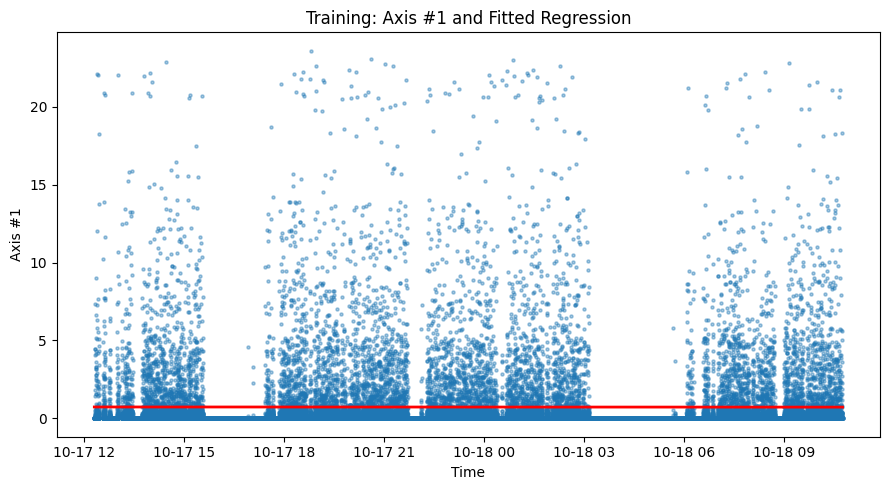

In [13]:
# 1) Training scatter and fitted line
plt.figure(figsize=(9,5))
plt.scatter(train['Time'], train['Axis #1'], s=5, alpha=0.4)
plt.plot(train['Time'], train['y_pred'], color='red', linewidth=2)
plt.title('Training: Axis #1 and Fitted Regression')
plt.xlabel('Time')
plt.ylabel('Axis #1')
plt.tight_layout()
plt.show()


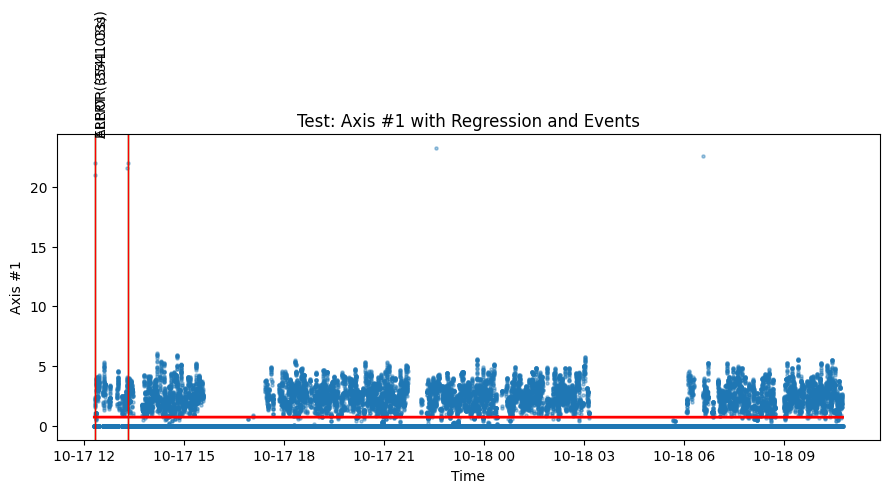

In [14]:
# 2) Test scatter, regression line, and event markers with duration annotations
plt.figure(figsize=(9,5))
plt.scatter(test['Time'], test['Axis #1'], s=5, alpha=0.4)
plt.plot(test['Time'], test['y_pred'], color='red', linewidth=2)
plt.title('Test: Axis #1 with Regression and Events')
plt.xlabel('Time')
plt.ylabel('Axis #1')

y_top = max(float(test['Axis #1'].max()), float(test['y_pred'].max()))
for ev in alerts + errors:
    plt.axvline(ev['start_time'], linewidth=1, color='green' if ev['level'] == 'ALERT' else 'red')
    plt.axvline(ev['end_time'], linewidth=1, color='green' if ev['level'] == 'ALERT' else 'red')
    dur = round(ev['duration_sec'], 2)
    plt.annotate(f"{ev['level']} ({dur}s)", xy=(ev['start_time'], y_top), xytext=(0, 10), textcoords='offset points', rotation=90)

plt.tight_layout()
plt.show()



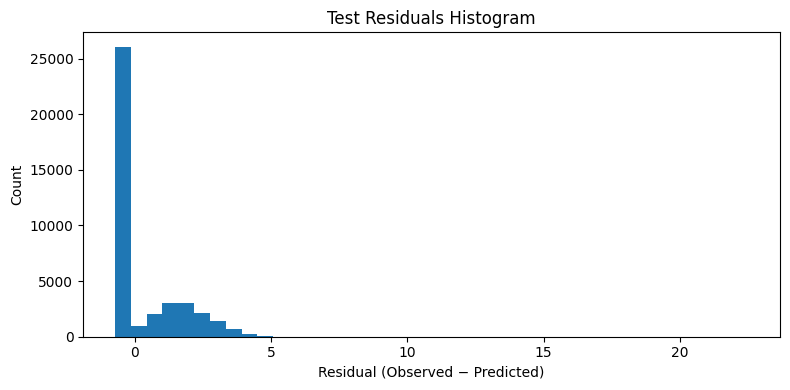

In [15]:
# 3) Residual histogram (test)
plt.figure(figsize=(8,4))
plt.hist(test['residual'], bins=40)
plt.title('Test Residuals Histogram')
plt.xlabel('Residual (Observed − Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



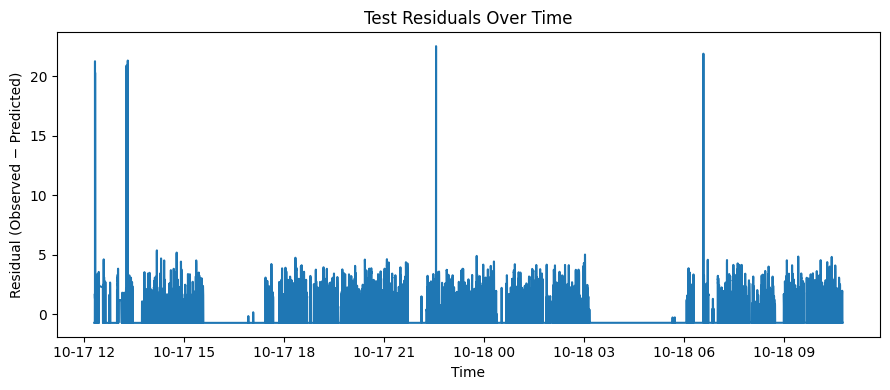

In [16]:
# 4) Residual over time (test)
plt.figure(figsize=(9,4))
plt.plot(test['Time'], test['residual'])
plt.title('Test Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Observed − Predicted)')
plt.tight_layout()
plt.show()

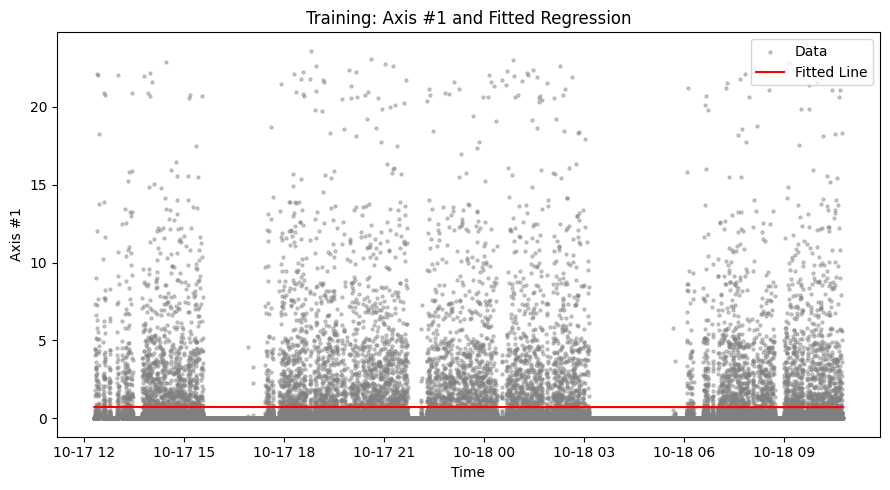

In [17]:
# 1) Training scatter and fitted line
plt.figure(figsize=(9,5))
plt.scatter(train['Time'], train['Axis #1'], s=5, alpha=0.4, color='gray', label='Data')
plt.plot(train['Time'], train['y_pred'], color='red', label='Fitted Line')
plt.title('Training: Axis #1 and Fitted Regression')
plt.xlabel('Time')
plt.ylabel('Axis #1')
plt.legend()
plt.tight_layout()
plt.show()




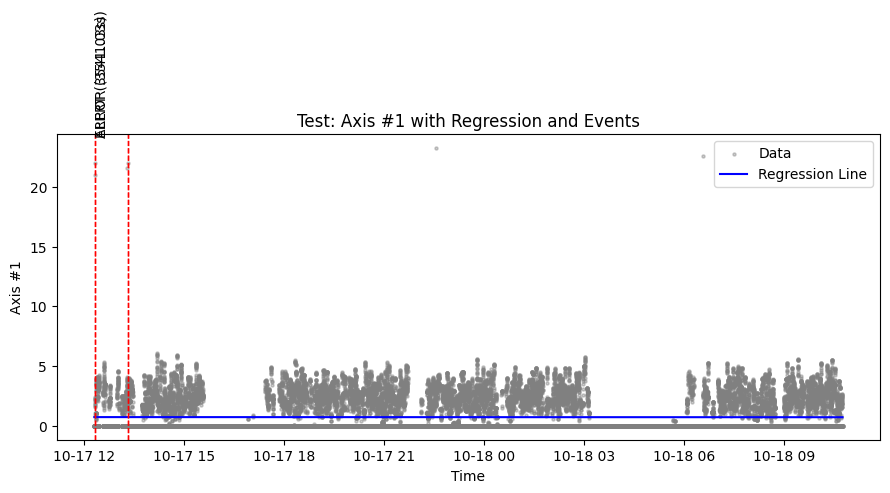

In [18]:
# 2) Test scatter, regression line, and event markers with duration annotations
plt.figure(figsize=(9,5))
plt.scatter(test['Time'], test['Axis #1'], s=5, alpha=0.4, color='gray', label='Data')
plt.plot(test['Time'], test['y_pred'], color='blue', label='Regression Line')
plt.title('Test: Axis #1 with Regression and Events')
plt.xlabel('Time')
plt.ylabel('Axis #1')

y_top = max(float(test['Axis #1'].max()), float(test['y_pred'].max()))
for ev in alerts + errors:
    if ev['level'] == 'alert':
        line_color = 'orange'
    else:
        line_color = 'red'
    plt.axvline(ev['start_time'], linewidth=1, color=line_color, linestyle='--')
    plt.axvline(ev['end_time'], linewidth=1, color=line_color, linestyle='--')
    dur = round(ev['duration_sec'], 2)
    plt.annotate(f"{ev['level']} ({dur}s)", xy=(ev['start_time'], y_top), 
                 xytext=(0, 10), textcoords='offset points', rotation=90)

plt.legend()
plt.tight_layout()
plt.show()



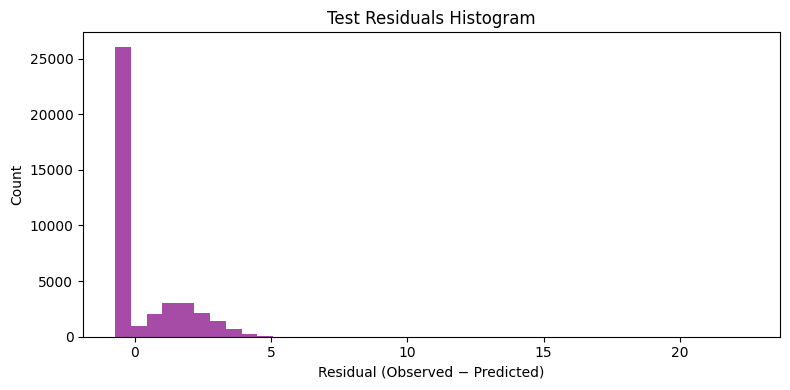

In [19]:
# 3) Residual histogram (test)
plt.figure(figsize=(8,4))
plt.hist(test['residual'], bins=40, color='purple', alpha=0.7)
plt.title('Test Residuals Histogram')
plt.xlabel('Residual (Observed − Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



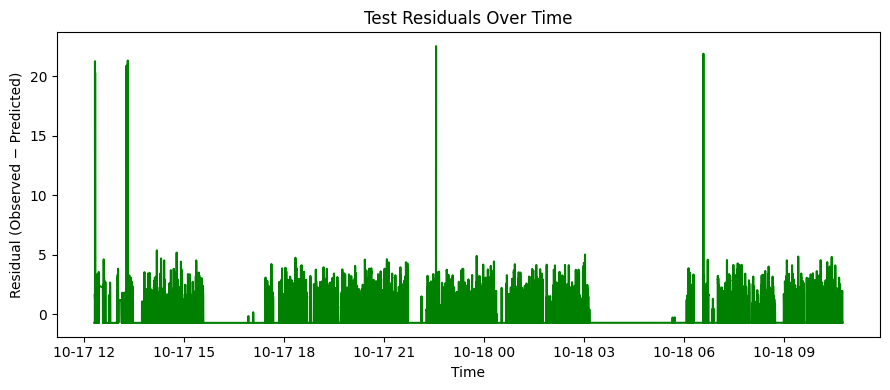

In [20]:
# 4) Residual over time (test)
plt.figure(figsize=(9,4))
plt.plot(test['Time'], test['residual'], color='green')
plt.title('Test Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Observed − Predicted)')
plt.tight_layout()
plt.show()

## Save events to CSV

In [21]:
events_df.to_csv(EVENTS_CSV, index=False)
print('Saved events to', EVENTS_CSV)
events_df.head(20)


# load the events CSV file and append the values of events_df to it
existing_events_df = pd.read_csv(EVENTS_CSV)
combined_events_df = pd.concat([existing_events_df, events_df], ignore_index=True)
combined_events_df.to_csv(EVENTS_CSV, index=False)
print('Updated events saved to', EVENTS_CSV)

Saved events to logs/axis_events.csv
Updated events saved to logs/axis_events.csv


In [22]:
df_train

Trait  Axis #1  Axis #2  Axis #3  Axis #4  Axis #5  Axis #6  Axis #7  \
0      current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
39667  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
39668  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
39669  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
39670  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
39671  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

       Axis #8 Axis #9 Axis #10 Axis #11 Axis #12 Axis #13 Axis #14  \
0          0.0    None     None     None     None     None     None   
1          0.0    None     None     None     None     None     None   
2          0.0    None     None     None     None     None     None   
3          0.0    None     None     None     None     None     None   
4          0.0    None     None     None     None     None     None   
...        ...     ...      ...      ...      ...      ...      ...   
39667      0.0    None     None     None     None     None     None   
39668      0.0    None     None     None     None     None     None   
39669      0.0    None     None     None     None     None     None   
39670      0.0    None     None     None     None     None     None   
39671      0.0    None     None     None     None     None     None   

                                  Time  
0     2022-10-17 12:18:23.660000+00:00  
1     2022-10-17 12:18:25.472000+00:00  
2     2022-10-17 12:18:27.348000+00:00  
3     2022-10-17 12:18:29.222000+00:00  
4     2022-10-17 12:18:31.117000+00:00  
...                                ...  
39667 2022-10-18 10:44:51.049000+00:00  
39668 2022-10-18 10:44:52.988000+00:00  
39669 2022-10-18 10:44:54.838000+00:00  
39670 2022-10-18 10:44:56.706000+00:00  
39671 2022-10-18 10:44:58.628000+00:00  

[39672 rows x 16 columns]

## Axis 2

Train Axis #2 rows: 39672  Test rows: 39672 

Train Axis #2 time range: 2022-10-17 12:18:23.660000+00:00 → 2022-10-18 10:44:58.628000+00:00
Test Axis #2 time range: 2022-10-17 12:18:23.660000+00:00 → 2022-10-18 10:44:58.628000+00:00
Slope: 2.1941926371642905e-06
Intercept: -3652.021021345644
Train positive residuals: 11662 of 39672
Test  positive residuals: 9592 of 39672
Quartile-based thresholds:
  MinC_q = 19.530314075980524  MaxC_q = 29.626081009854722  [q1, q3, IQR]= (np.float64(2.7040358528568627), np.float64(9.434547142106327), np.float64(6.730511289249464))
Std-based thresholds:
  MinC_s = 24.01987695774617  MaxC_s = 31.849728973018514  [mean, std]= (np.float64(8.360172927201482), np.float64(7.829852015272344))

Using quartile-based thresholds by default: MinC= 19.530314075980524  MaxC= 29.626081009854722
Estimated T (sec): 99.8015
Estimated T (sec): 4.0
seg                                   Time         t_sec    Axis #2    y_pred  \
32229 2022-10-18 06:34:43.695000+00:00  1.666

C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))


axis event_id  level                       start_time  \
0  Axis #2    A0001  ALERT 2022-10-18 06:34:43.695000+00:00   

                          end_time  duration_sec  peak_residual  \
0 2022-10-18 10:10:51.300000+00:00     12967.605      24.063928   

   mean_residual  area_above_baseline  
0       2.064816         17951.857075

Total Alerts: 1  Total Errors: 0


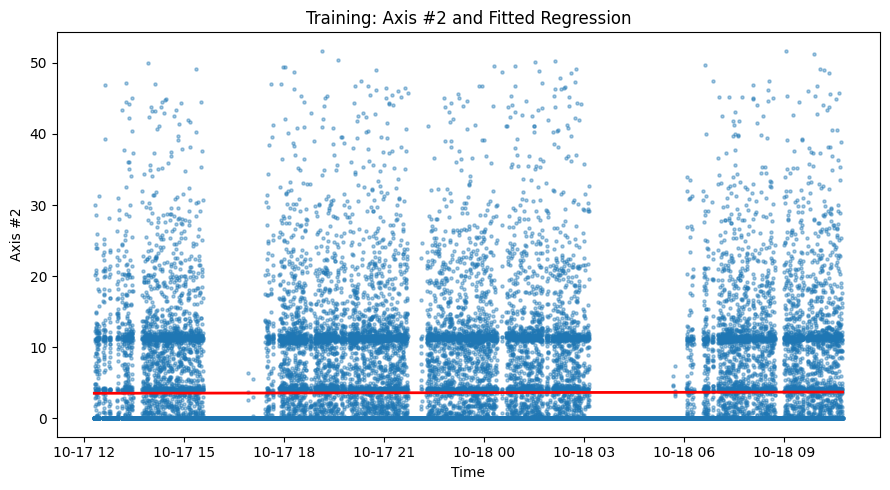

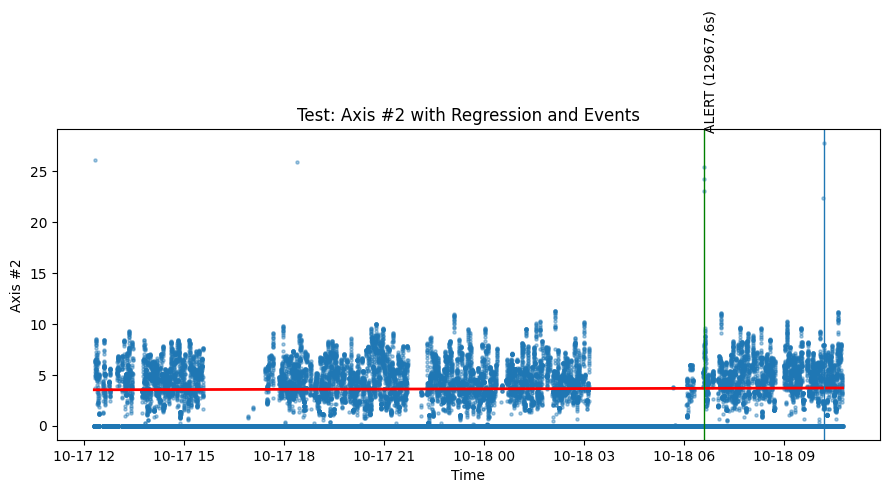

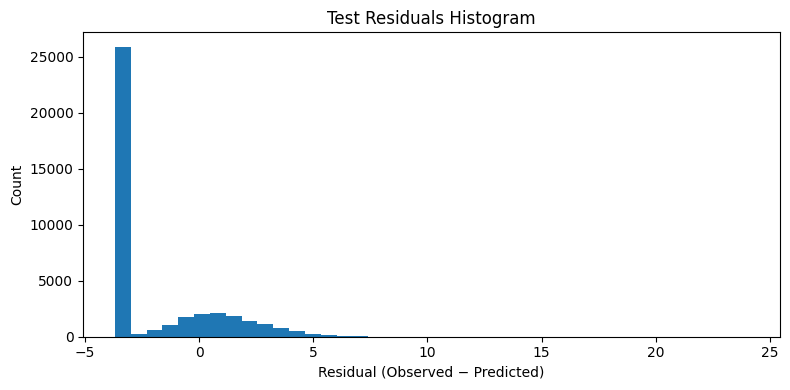

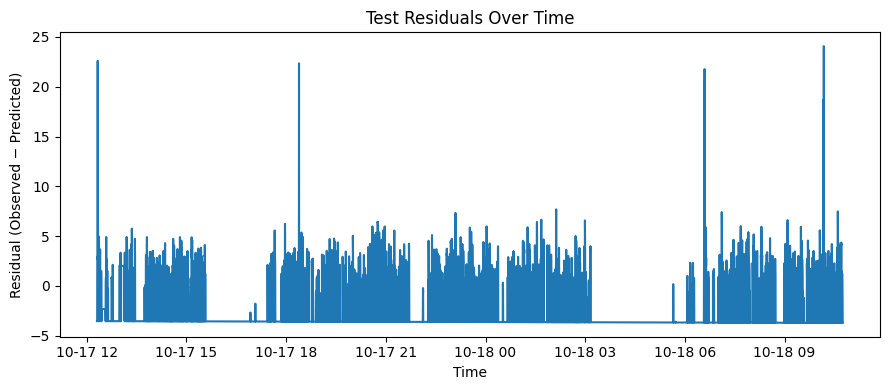

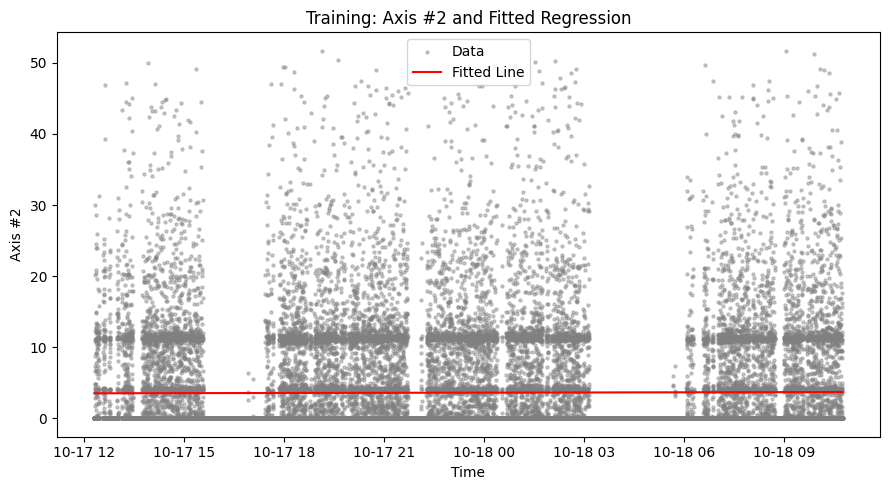

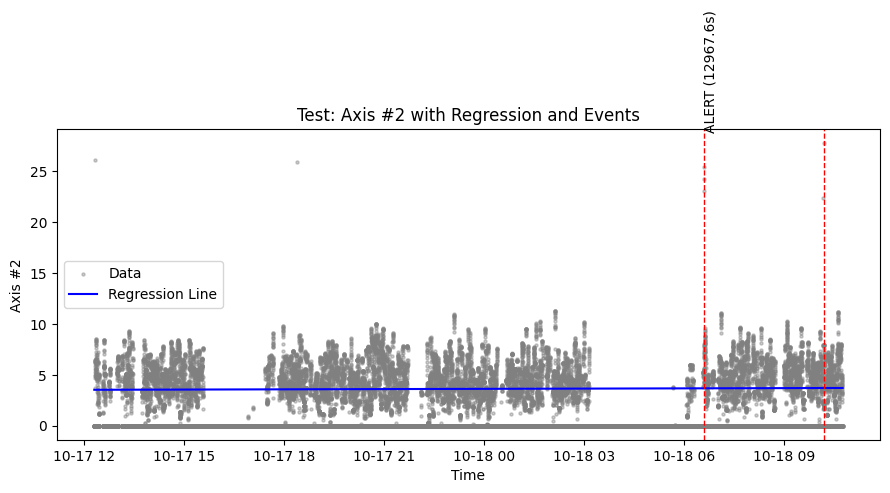

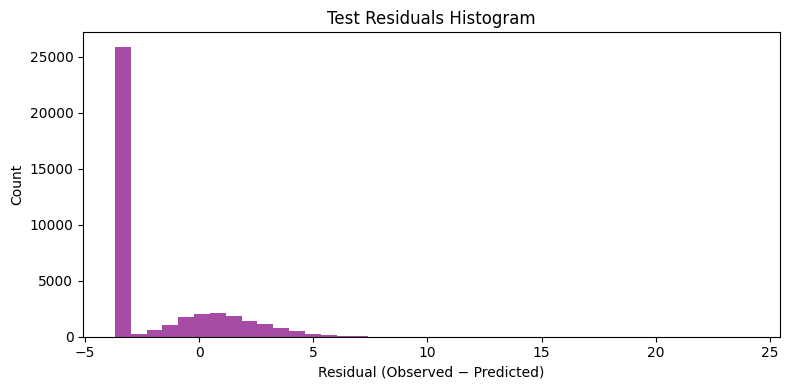

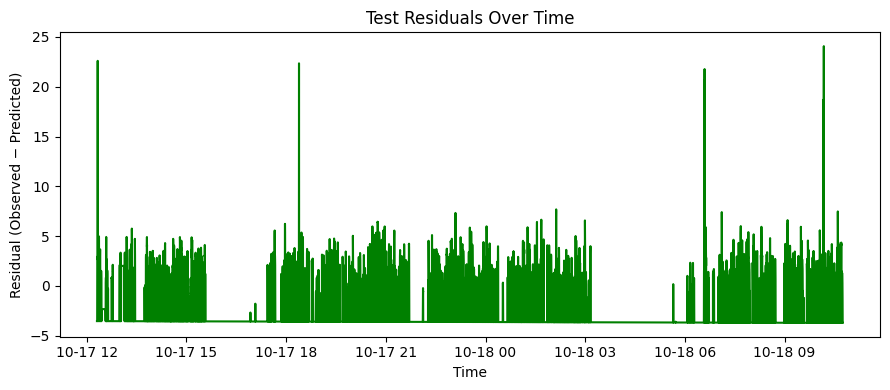

Updated events saved to logs/axis_events.csv


In [23]:
axis_name = 'Axis #2'

train_axis_with_time_df = load_axis_with_time(df_train, axis_name)
test_axis_with_time_df = load_axis_with_time(df_test, axis_name)


print('Train ' + axis_name + ' rows:', len(train_axis_with_time_df), ' Test rows:', len(test_axis1_with_time_df), '\n')
print('Train ' + axis_name + ' time range:', train_axis_with_time_df['Time'].min(), '→', train_axis_with_time_df['Time'].max())
print('Test ' + axis_name + ' time range:', test_axis1_with_time_df['Time'].min(),  '→', test_axis1_with_time_df['Time'].max())


train = train_axis_with_time_df.copy()
test  = test_axis_with_time_df.copy()

X_train = train[['t_sec']].values
y_train = train[axis_name].values

model = LinearRegression()
model.fit(X_train, y_train)

slope = float(model.coef_[0])
intercept = float(model.intercept_)
print('Slope:', slope)
print('Intercept:', intercept)

# Train residuals (for threshold derivation)
train['y_pred'] = model.predict(train[['t_sec']].values)
train['residual'] = train[axis_name] - train['y_pred']
train_pos = train[train['residual'] > 0].copy()

# Test residuals (for detection)
test['y_pred'] = model.predict(test[['t_sec']].values)
test['residual'] = test[axis_name] - test['y_pred']
test_pos = test[test['residual'] > 0].copy()

print('Train positive residuals:', len(train_pos), 'of', len(train))
print('Test  positive residuals:', len(test_pos),  'of', len(test))

train_pos_vals = train_pos['residual'].values

if len(train_pos_vals) == 0:
    # Fallback if no positive residuals in training
    minC_q = maxC_q = 0.0
    q_stats = (0, 0, 0)
    minC_s = maxC_s = 0.0
    s_stats = (0, 0)
else:
    minC_q, maxC_q, q_stats = threshold_quartile(train_pos_vals)
    minC_s, maxC_s, s_stats = threshold_std(train_pos_vals)

print('Quartile-based thresholds:')
print('  MinC_q =', minC_q, ' MaxC_q =', maxC_q, ' [q1, q3, IQR]=', q_stats)
print('Std-based thresholds:')
print('  MinC_s =', minC_s, ' MaxC_s =', maxC_s, ' [mean, std]=', s_stats)

# Choose which thresholds to use for detection
MinC = float(minC_q)
MaxC = float(maxC_q)
print('\nUsing quartile-based thresholds by default: MinC=', MinC, ' MaxC=', MaxC)

train_runs = detect_runs_above_threshold(train, MinC, grace_sec=2.0)
durations = [r['duration_sec'] for r in train_runs]
if len(durations) == 0:
    T = 2.0
else:
    T = max(2.0, float(np.percentile(durations, 95)))
    

print('Estimated T (sec):', T)


# Median dt from ALL training timestamps (sorted)
t_train = (train['Time'].astype('int64') // 10**9).values.astype(float)
dt_all = np.diff(t_train) if len(t_train) >= 2 else np.array([2.0])
median_dt = float(np.median(dt_all)) if len(dt_all) else 2.0

# Choose how many consecutive samples you require above threshold
N = 2  # we will try 2 first. we can raise to 5–10 for stricter persistence

# Final persistence time
T = max(2.0, N * median_dt)
print("Estimated T (sec):", T)



alerts, errors = detect_events(test, MinC, MaxC, T, grace_sec=2.0)
events_df = pd.DataFrame(alerts + errors, columns=[
    'event_id','level','start_time','end_time','duration_sec','peak_residual','mean_residual','area_above_baseline'
])


# prepend a column to events_df
events_df.insert(0, 'axis', axis_name)

print('Detected events:')
display(events_df.head(20))
print('Total Alerts:', len(alerts), ' Total Errors:', len(errors))


# 1) Training scatter and fitted line
plt.figure(figsize=(9,5))
plt.scatter(train['Time'], train[axis_name], s=5, alpha=0.4)
plt.plot(train['Time'], train['y_pred'], color='red', linewidth=2)
plt.title('Training: '+ axis_name +' and Fitted Regression')
plt.xlabel('Time')
plt.ylabel(axis_name)
plt.tight_layout()
plt.show()


# 2) Test scatter, regression line, and event markers with duration annotations
plt.figure(figsize=(9,5))
plt.scatter(test['Time'], test[axis_name], s=5, alpha=0.4)
plt.plot(test['Time'], test['y_pred'], color='red', linewidth=2)
plt.title('Test: ' + axis_name + ' with Regression and Events')
plt.xlabel('Time')
plt.ylabel(axis_name)

y_top = max(float(test[axis_name].max()), float(test['y_pred'].max()))
for ev in alerts + errors:
    plt.axvline(ev['start_time'], linewidth=1, color='green' if ev['level'] == 'ALERT' else 'red')
    plt.axvline(ev['end_time'], linewidth=1)
    dur = round(ev['duration_sec'], 2)
    plt.annotate(f"{ev['level']} ({dur}s)", xy=(ev['start_time'], y_top), xytext=(0, 10), textcoords='offset points', rotation=90)

plt.tight_layout()
plt.show()


# 3) Residual histogram (test)
plt.figure(figsize=(8,4))
plt.hist(test['residual'], bins=40)
plt.title('Test Residuals Histogram')
plt.xlabel('Residual (Observed − Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 4) Residual over time (test)
plt.figure(figsize=(9,4))
plt.plot(test['Time'], test['residual'])
plt.title('Test Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Observed − Predicted)')
plt.tight_layout()
plt.show()



# 1) Training scatter and fitted line
plt.figure(figsize=(9,5))
plt.scatter(train['Time'], train[axis_name], s=5, alpha=0.4, color='gray', label='Data')
plt.plot(train['Time'], train['y_pred'], color='red', label='Fitted Line')
plt.title('Training: '+ axis_name +' and Fitted Regression')
plt.xlabel('Time')
plt.ylabel(axis_name)
plt.legend()
plt.tight_layout()
plt.show()


# 2) Test scatter, regression line, and event markers with duration annotations
plt.figure(figsize=(9,5))
plt.scatter(test['Time'], test[axis_name], s=5, alpha=0.4, color='gray', label='Data')
plt.plot(test['Time'], test['y_pred'], color='blue', label='Regression Line')
plt.title('Test: ' + axis_name + ' with Regression and Events')
plt.xlabel('Time')
plt.ylabel(axis_name)

y_top = max(float(test[axis_name].max()), float(test['y_pred'].max()))
for ev in alerts + errors:
    if ev['level'] == 'alert':
        line_color = 'orange'
    else:
        line_color = 'red'
    plt.axvline(ev['start_time'], linewidth=1, color=line_color, linestyle='--')
    plt.axvline(ev['end_time'], linewidth=1, color=line_color, linestyle='--')
    dur = round(ev['duration_sec'], 2)
    plt.annotate(f"{ev['level']} ({dur}s)", xy=(ev['start_time'], y_top), 
                 xytext=(0, 10), textcoords='offset points', rotation=90)

plt.legend()
plt.tight_layout()
plt.show()

# 3) Residual histogram (test)
plt.figure(figsize=(8,4))
plt.hist(test['residual'], bins=40, color='purple', alpha=0.7)
plt.title('Test Residuals Histogram')
plt.xlabel('Residual (Observed − Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# 4) Residual over time (test)
plt.figure(figsize=(9,4))
plt.plot(test['Time'], test['residual'], color='green')
plt.title('Test Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Observed − Predicted)')
plt.tight_layout()
plt.show()


# load the events CSV file and append the values of events_df to it
existing_events_df = pd.read_csv(EVENTS_CSV)
combined_events_df = pd.concat([existing_events_df, events_df], ignore_index=True)
combined_events_df.to_csv(EVENTS_CSV, index=False)
print('Updated events saved to', EVENTS_CSV)

## Axis 3

Train Axis #3 rows: 39672  Test rows: 39672 

Train Axis #3 time range: 2022-10-17 12:18:23.660000+00:00 → 2022-10-18 10:44:58.628000+00:00
Test Axis #3 time range: 2022-10-17 12:18:23.660000+00:00 → 2022-10-18 10:44:58.628000+00:00
Slope: -5.777472612425599e-07
Intercept: 965.2660956089132
Train positive residuals: 12042 of 39672
Test  positive residuals: 13808 of 39672
Quartile-based thresholds:
  MinC_q = 12.96224869472551  MaxC_q = 18.830512534672046  [q1, q3, IQR]= (np.float64(3.1818089614812797), np.float64(7.093984854778972), np.float64(3.912175893297692))
Std-based thresholds:
  MinC_s = 17.651700289118565  MaxC_s = 23.47345614743015  [mean, std]= (np.float64(6.008188572495412), np.float64(5.821755858311578))

Using quartile-based thresholds by default: MinC= 12.96224869472551  MaxC= 18.830512534672046
Estimated T (sec): 55.21619999999999
Estimated T (sec): 4.0
seg                                  Time         t_sec    Axis #3    y_pred  \
2439 2022-10-17 13:52:28.119000+00:00 

C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))
C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))
C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))
C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))
C:\Users\lopez\AppData\Local\Tem

axis event_id  level                       start_time  \
0   Axis #3    A0001  ALERT 2022-10-17 13:52:28.119000+00:00   
1   Axis #3    A0002  ALERT 2022-10-17 14:04:34.379000+00:00   
2   Axis #3    A0003  ALERT 2022-10-17 15:32:54.376000+00:00   
3   Axis #3    A0004  ALERT 2022-10-17 18:21:13.788000+00:00   
4   Axis #3    A0005  ALERT 2022-10-17 18:38:28.285000+00:00   
5   Axis #3    A0006  ALERT 2022-10-17 19:33:17.581000+00:00   
6   Axis #3    A0007  ALERT 2022-10-17 21:23:43.472000+00:00   
7   Axis #3    A0008  ALERT 2022-10-17 21:33:53.629000+00:00   
8   Axis #3    A0009  ALERT 2022-10-17 22:30:51.590000+00:00   
9   Axis #3    A0010  ALERT 2022-10-17 22:59:12.121000+00:00   
10  Axis #3    A0011  ALERT 2022-10-17 23:18:05.615000+00:00   
11  Axis #3    A0012  ALERT 2022-10-18 01:05:59.978000+00:00   
12  Axis #3    A0013  ALERT 2022-10-18 06:42:15.187000+00:00   
13  Axis #3    A0014  ALERT 2022-10-18 08:19:14.519000+00:00   
14  Axis #3    A0015  ALERT 2022-10-18 08:24:50.155000+00:00   
15  Axis #3    A0016  ALERT 2022-10-18 08:25:49.377000+00:00   
16  Axis #3    A0017  ALERT 2022-10-18 10:36:54.924000+00:00   
17  Axis #3    E0001  ERROR 2022-10-17 12:19:37.918000+00:00   

                           end_time  duration_sec  peak_residual  \
0  2022-10-17 13:52:37.509000+00:00         9.390      13.439197   
1  2022-10-17 14:04:43.911000+00:00         9.532      14.158397   
2  2022-10-17 15:33:15.239000+00:00        20.863      14.008292   
3  2022-10-17 18:21:19.539000+00:00         5.751      13.114667   
4  2022-10-17 18:38:37.956000+00:00         9.671      14.156345   
5  2022-10-17 19:33:25.355000+00:00         7.774      13.198252   
6  2022-10-17 21:23:56.896000+00:00        13.424      14.116933   
7  2022-10-17 21:34:03.252000+00:00         9.623      14.732404   
8  2022-10-17 22:31:07.009000+00:00        15.419      15.817320   
9  2022-10-17 22:59:17.871000+00:00         5.750      13.341254   
10 2022-10-17 23:18:18.877000+00:00        13.262      14.888962   
11 2022-10-18 01:06:11.381000+00:00        11.403      14.484106   
12 2022-10-18 06:42:22.616000+00:00         7.429      13.735766   
13 2022-10-18 08:19:22.121000+00:00         7.602      13.656114   
14 2022-10-18 08:24:57.787000+00:00         7.632      13.403655   
15 2022-10-18 08:25:55.018000+00:00         5.641      13.109819   
16 2022-10-18 10:37:02.644000+00:00         7.720      13.469503   
17 2022-10-17 18:19:38.640000+00:00     21600.722     119.798975   

    mean_residual  area_above_baseline  
0       13.364468           120.560374  
1       13.851920           124.913149  
2       13.471782           283.117491  
3       13.107484            78.656771  
4       14.101491           127.035837  
5       13.167931           105.333339  
6       13.749089           179.681487  
7       14.476263           145.636313  
8       14.946668           241.974832  
9       13.271594            66.334753  
10      14.277475           187.246979  
11      14.112635           170.134124  
12      13.462043            94.706710  
13      13.503095           108.439549  
14      13.241599            92.819635  
15      13.068122            78.420993  
16      13.195706           105.853468  
17       7.578699        115992.882005

Total Alerts: 17  Total Errors: 1


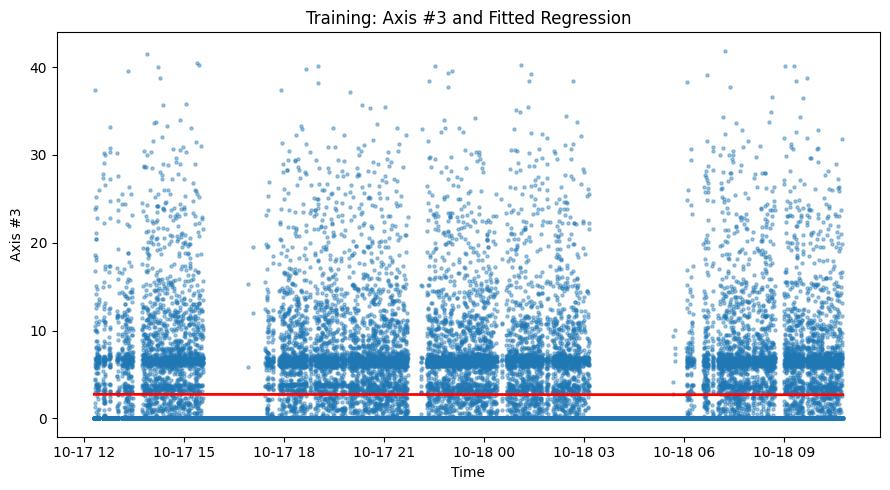

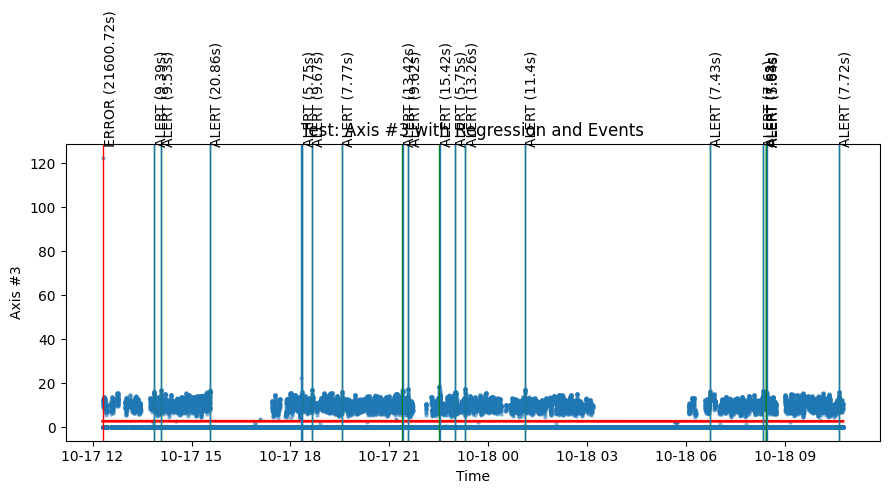

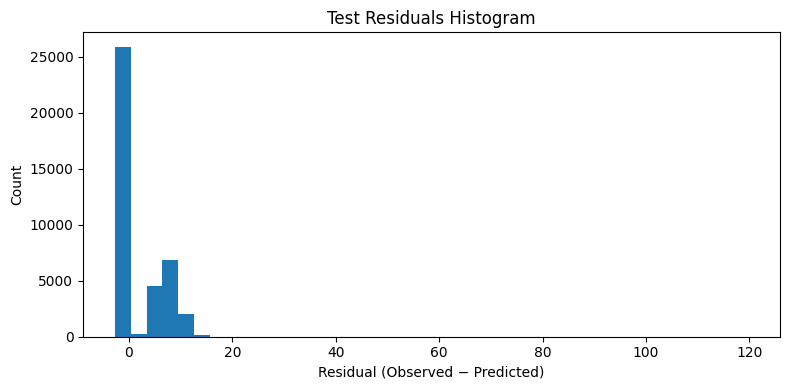

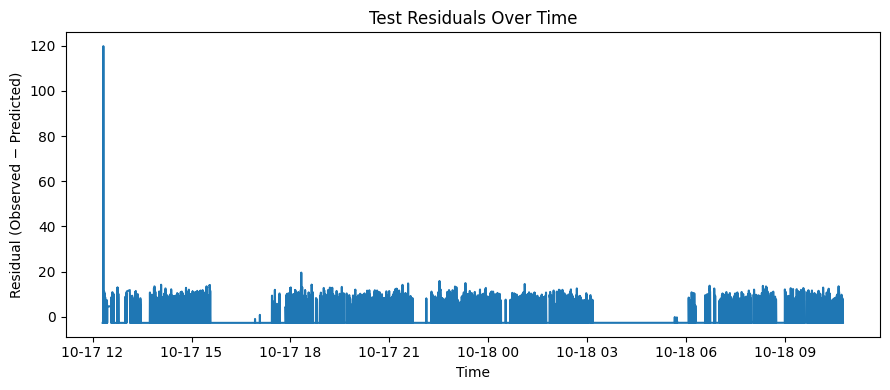

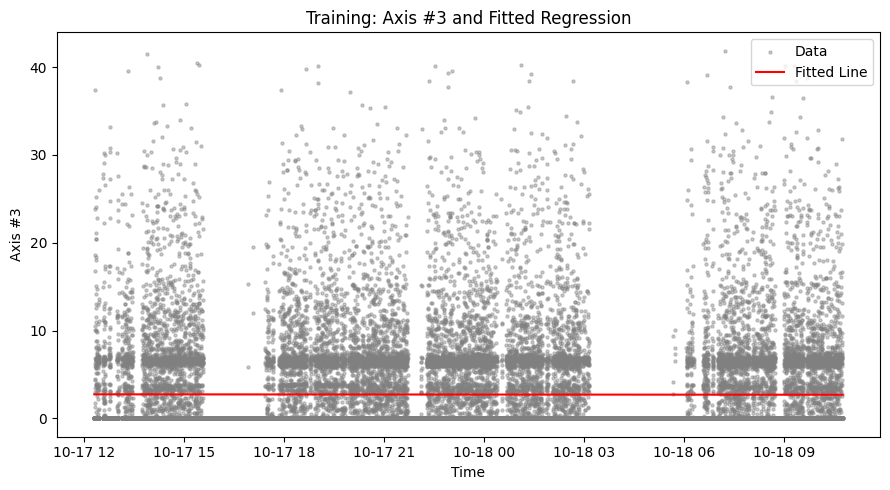

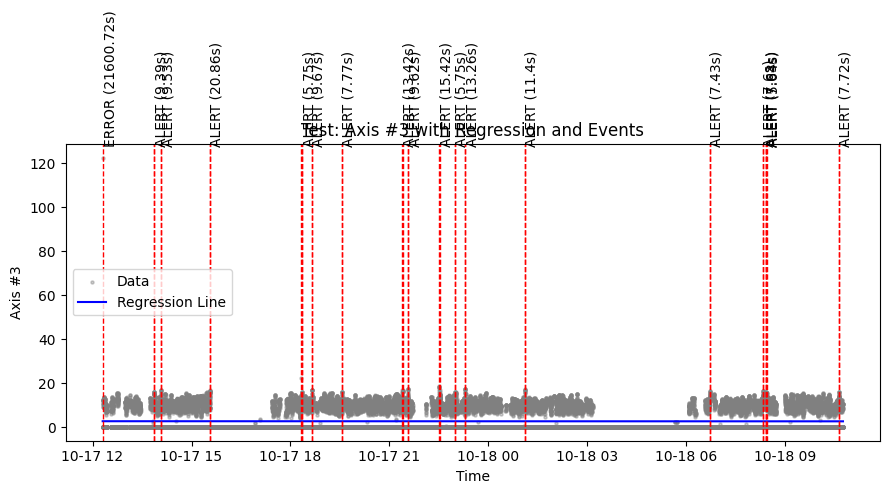

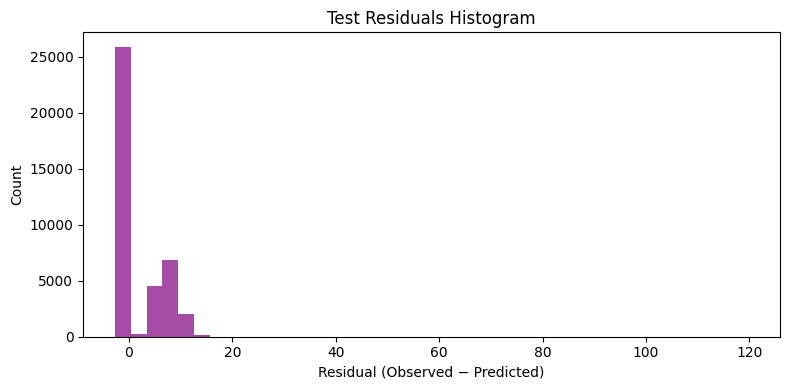

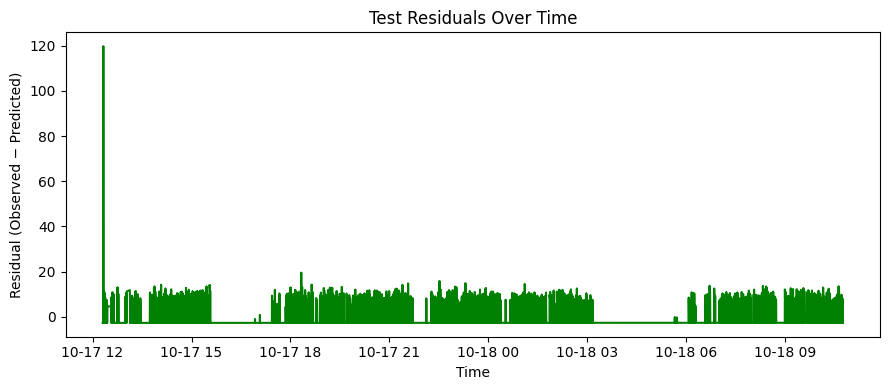

Updated events saved to logs/axis_events.csv


In [24]:
axis_name = 'Axis #3'

train_axis_with_time_df = load_axis_with_time(df_train, axis_name)
test_axis_with_time_df = load_axis_with_time(df_test, axis_name)


print('Train ' + axis_name + ' rows:', len(train_axis_with_time_df), ' Test rows:', len(test_axis1_with_time_df), '\n')
print('Train ' + axis_name + ' time range:', train_axis_with_time_df['Time'].min(), '→', train_axis_with_time_df['Time'].max())
print('Test ' + axis_name + ' time range:', test_axis1_with_time_df['Time'].min(),  '→', test_axis1_with_time_df['Time'].max())


train = train_axis_with_time_df.copy()
test  = test_axis_with_time_df.copy()

X_train = train[['t_sec']].values
y_train = train[axis_name].values

model = LinearRegression()
model.fit(X_train, y_train)

slope = float(model.coef_[0])
intercept = float(model.intercept_)
print('Slope:', slope)
print('Intercept:', intercept)

# Train residuals (for threshold derivation)
train['y_pred'] = model.predict(train[['t_sec']].values)
train['residual'] = train[axis_name] - train['y_pred']
train_pos = train[train['residual'] > 0].copy()

# Test residuals (for detection)
test['y_pred'] = model.predict(test[['t_sec']].values)
test['residual'] = test[axis_name] - test['y_pred']
test_pos = test[test['residual'] > 0].copy()

print('Train positive residuals:', len(train_pos), 'of', len(train))
print('Test  positive residuals:', len(test_pos),  'of', len(test))

train_pos_vals = train_pos['residual'].values

if len(train_pos_vals) == 0:
    # Fallback if no positive residuals in training
    minC_q = maxC_q = 0.0
    q_stats = (0, 0, 0)
    minC_s = maxC_s = 0.0
    s_stats = (0, 0)
else:
    minC_q, maxC_q, q_stats = threshold_quartile(train_pos_vals)
    minC_s, maxC_s, s_stats = threshold_std(train_pos_vals)

print('Quartile-based thresholds:')
print('  MinC_q =', minC_q, ' MaxC_q =', maxC_q, ' [q1, q3, IQR]=', q_stats)
print('Std-based thresholds:')
print('  MinC_s =', minC_s, ' MaxC_s =', maxC_s, ' [mean, std]=', s_stats)

# Choose which thresholds to use for detection
MinC = float(minC_q)
MaxC = float(maxC_q)
print('\nUsing quartile-based thresholds by default: MinC=', MinC, ' MaxC=', MaxC)

train_runs = detect_runs_above_threshold(train, MinC, grace_sec=2.0)
durations = [r['duration_sec'] for r in train_runs]
if len(durations) == 0:
    T = 2.0
else:
    T = max(2.0, float(np.percentile(durations, 95)))
    

print('Estimated T (sec):', T)


# Median dt from ALL training timestamps (sorted)
t_train = (train['Time'].astype('int64') // 10**9).values.astype(float)
dt_all = np.diff(t_train) if len(t_train) >= 2 else np.array([2.0])
median_dt = float(np.median(dt_all)) if len(dt_all) else 2.0

# Choose how many consecutive samples you require above threshold
N = 2  # we will try 2 first. we can raise to 5–10 for stricter persistence

# Final persistence time
T = max(2.0, N * median_dt)
print("Estimated T (sec):", T)



alerts, errors = detect_events(test, MinC, MaxC, T, grace_sec=2.0)
events_df = pd.DataFrame(alerts + errors, columns=[
    'event_id','level','start_time','end_time','duration_sec','peak_residual','mean_residual','area_above_baseline'
])


# prepend a column to events_df
events_df.insert(0, 'axis', axis_name)

print('Detected events:')
display(events_df.head(20))
print('Total Alerts:', len(alerts), ' Total Errors:', len(errors))


# 1) Training scatter and fitted line
plt.figure(figsize=(9,5))
plt.scatter(train['Time'], train[axis_name], s=5, alpha=0.4)
plt.plot(train['Time'], train['y_pred'], color='red', linewidth=2)
plt.title('Training: '+ axis_name +' and Fitted Regression')
plt.xlabel('Time')
plt.ylabel(axis_name)
plt.tight_layout()
plt.show()


# 2) Test scatter, regression line, and event markers with duration annotations
plt.figure(figsize=(9,5))
plt.scatter(test['Time'], test[axis_name], s=5, alpha=0.4)
plt.plot(test['Time'], test['y_pred'], color='red', linewidth=2)
plt.title('Test: ' + axis_name + ' with Regression and Events')
plt.xlabel('Time')
plt.ylabel(axis_name)

y_top = max(float(test[axis_name].max()), float(test['y_pred'].max()))
for ev in alerts + errors:
    plt.axvline(ev['start_time'], linewidth=1, color='green' if ev['level'] == 'ALERT' else 'red')
    plt.axvline(ev['end_time'], linewidth=1)
    dur = round(ev['duration_sec'], 2)
    plt.annotate(f"{ev['level']} ({dur}s)", xy=(ev['start_time'], y_top), xytext=(0, 10), textcoords='offset points', rotation=90)

plt.tight_layout()
plt.show()


# 3) Residual histogram (test)
plt.figure(figsize=(8,4))
plt.hist(test['residual'], bins=40)
plt.title('Test Residuals Histogram')
plt.xlabel('Residual (Observed − Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 4) Residual over time (test)
plt.figure(figsize=(9,4))
plt.plot(test['Time'], test['residual'])
plt.title('Test Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Observed − Predicted)')
plt.tight_layout()
plt.show()



# 1) Training scatter and fitted line
plt.figure(figsize=(9,5))
plt.scatter(train['Time'], train[axis_name], s=5, alpha=0.4, color='gray', label='Data')
plt.plot(train['Time'], train['y_pred'], color='red', label='Fitted Line')
plt.title('Training: '+ axis_name +' and Fitted Regression')
plt.xlabel('Time')
plt.ylabel(axis_name)
plt.legend()
plt.tight_layout()
plt.show()


# 2) Test scatter, regression line, and event markers with duration annotations
plt.figure(figsize=(9,5))
plt.scatter(test['Time'], test[axis_name], s=5, alpha=0.4, color='gray', label='Data')
plt.plot(test['Time'], test['y_pred'], color='blue', label='Regression Line')
plt.title('Test: ' + axis_name + ' with Regression and Events')
plt.xlabel('Time')
plt.ylabel(axis_name)

y_top = max(float(test[axis_name].max()), float(test['y_pred'].max()))
for ev in alerts + errors:
    if ev['level'] == 'alert':
        line_color = 'orange'
    else:
        line_color = 'red'
    plt.axvline(ev['start_time'], linewidth=1, color=line_color, linestyle='--')
    plt.axvline(ev['end_time'], linewidth=1, color=line_color, linestyle='--')
    dur = round(ev['duration_sec'], 2)
    plt.annotate(f"{ev['level']} ({dur}s)", xy=(ev['start_time'], y_top), 
                 xytext=(0, 10), textcoords='offset points', rotation=90)

plt.legend()
plt.tight_layout()
plt.show()

# 3) Residual histogram (test)
plt.figure(figsize=(8,4))
plt.hist(test['residual'], bins=40, color='purple', alpha=0.7)
plt.title('Test Residuals Histogram')
plt.xlabel('Residual (Observed − Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# 4) Residual over time (test)
plt.figure(figsize=(9,4))
plt.plot(test['Time'], test['residual'], color='green')
plt.title('Test Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Observed − Predicted)')
plt.tight_layout()
plt.show()


# load the events CSV file and append the values of events_df to it
existing_events_df = pd.read_csv(EVENTS_CSV)
combined_events_df = pd.concat([existing_events_df, events_df], ignore_index=True)
combined_events_df.to_csv(EVENTS_CSV, index=False)
print('Updated events saved to', EVENTS_CSV)

Train Axis #4 rows: 39672  Test rows: 39672 

Train Axis #4 time range: 2022-10-17 12:18:23.660000+00:00 → 2022-10-18 10:44:58.628000+00:00
Test Axis #4 time range: 2022-10-17 12:18:23.660000+00:00 → 2022-10-18 10:44:58.628000+00:00
Slope: 3.8900305584851903e-07
Intercept: -647.4782753838234
Train positive residuals: 9397 of 39672
Test  positive residuals: 13667 of 39672
Quartile-based thresholds:
  MinC_q = 5.031858189324278  MaxC_q = 7.8635349034756175  [q1, q3, IQR]= (np.float64(0.31239699907204577), np.float64(2.2001814751729385), np.float64(1.8877844761008928))
Std-based thresholds:
  MinC_s = 6.709387623050738  MaxC_s = 9.131737145750156  [mean, std]= (np.float64(1.8646885776518987), np.float64(2.4223495226994194))

Using quartile-based thresholds by default: MinC= 5.031858189324278  MaxC= 7.8635349034756175
Estimated T (sec): 157.10159999999996
Estimated T (sec): 4.0
seg                                   Time         t_sec    Axis #4    y_pred  \
10363 2022-10-17 18:19:42.378000

C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))
C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))
C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))


axis event_id  level                       start_time  \
0  Axis #4    A0001  ALERT 2022-10-17 18:19:42.378000+00:00   
1  Axis #4    A0002  ALERT 2022-10-18 09:09:47.925000+00:00   
2  Axis #4    E0001  ERROR 2022-10-17 18:19:30.913000+00:00   

                          end_time  duration_sec  peak_residual  \
0 2022-10-17 18:19:50.228000+00:00         7.850      21.815127   
1 2022-10-18 09:09:57.304000+00:00         9.379       5.313732   
2 2022-10-17 18:19:50.228000+00:00        19.315      21.815127   

   mean_residual  area_above_baseline  
0       9.241190            49.624419  
1       5.244266            52.715437  
2       6.968315           110.633264

Total Alerts: 2  Total Errors: 1


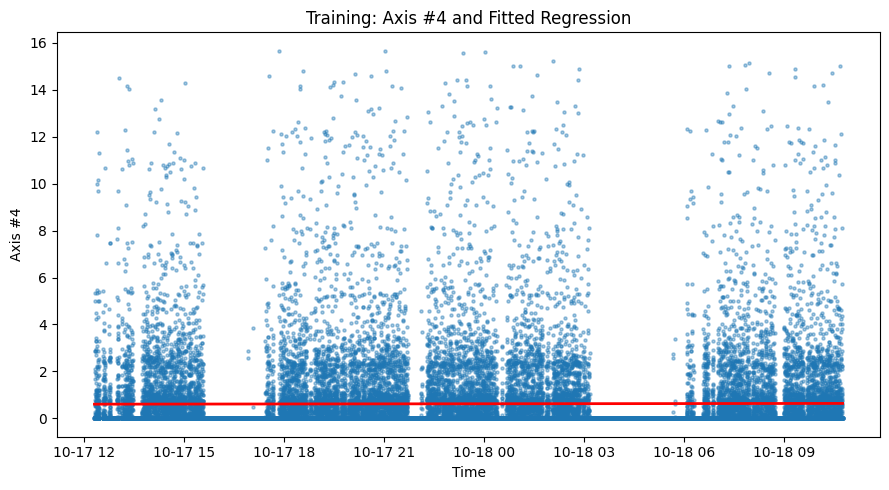

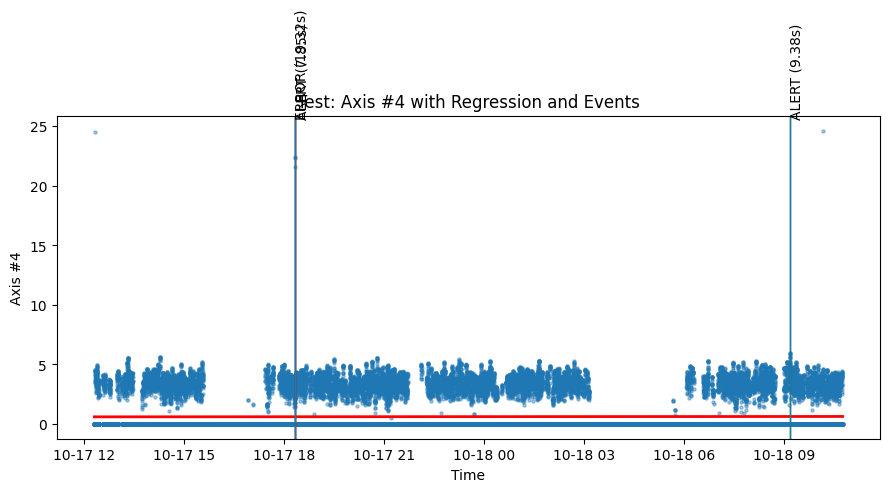

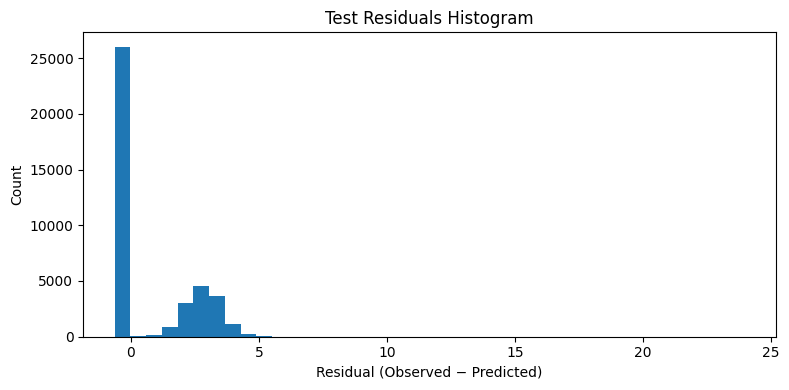

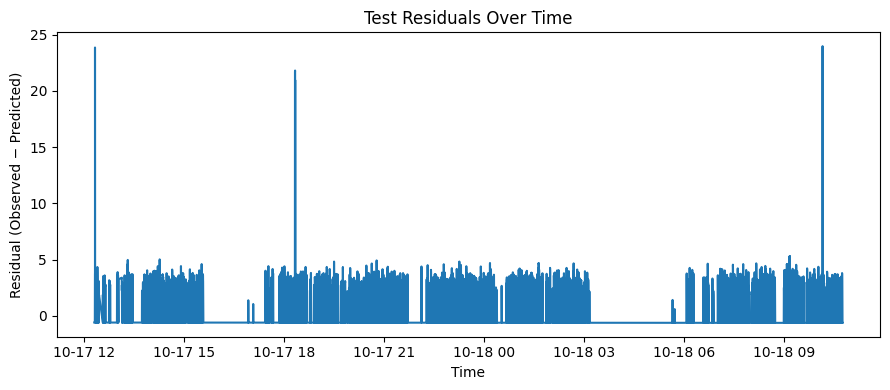

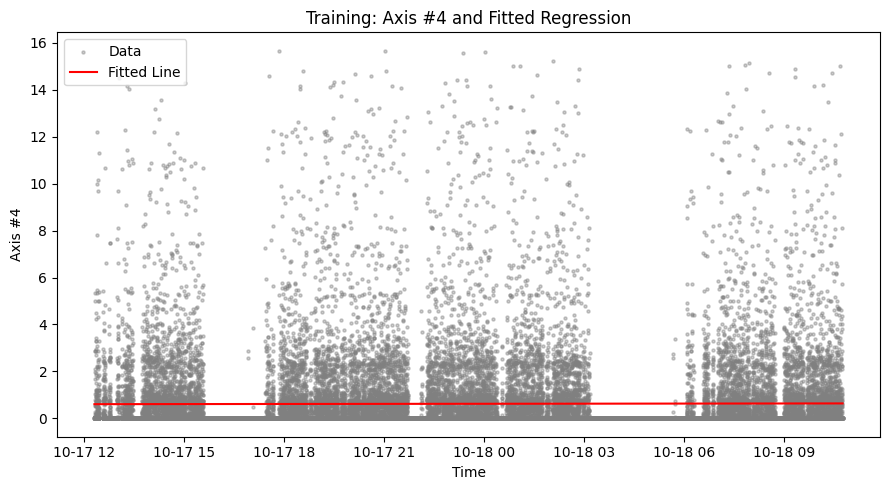

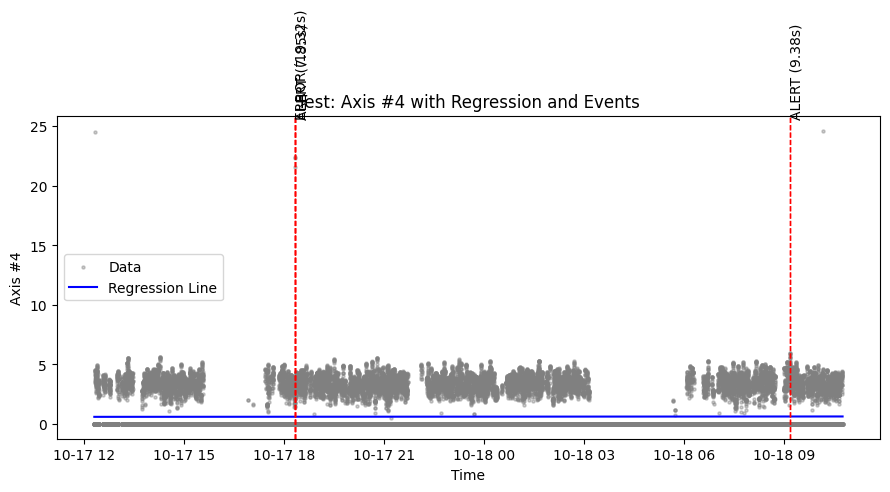

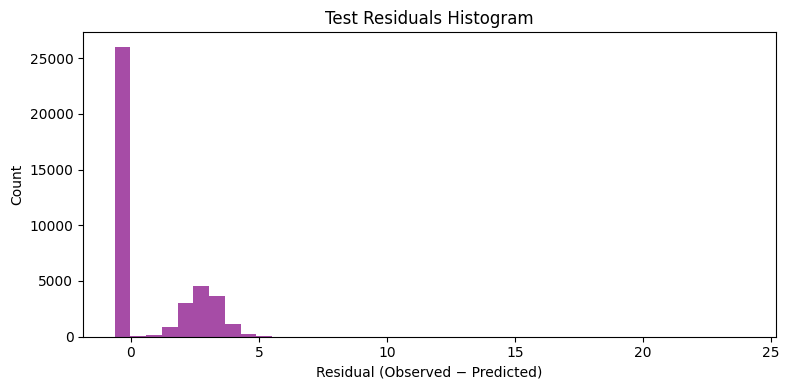

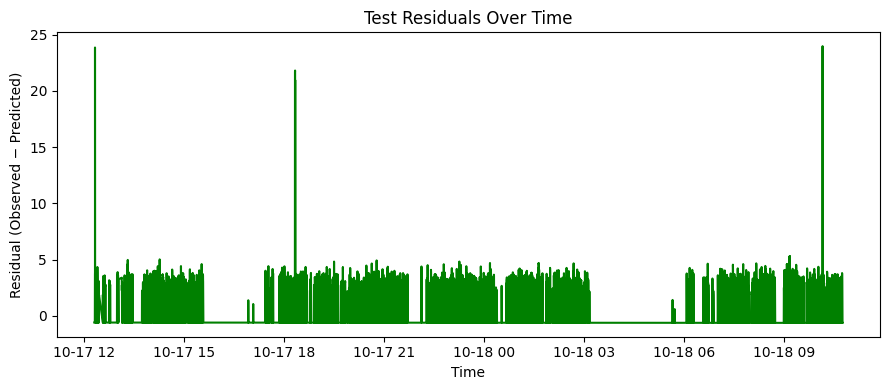

Updated events saved to logs/axis_events.csv


In [25]:
axis_name = 'Axis #4'

train_axis_with_time_df = load_axis_with_time(df_train, axis_name)
test_axis_with_time_df = load_axis_with_time(df_test, axis_name)


print('Train ' + axis_name + ' rows:', len(train_axis_with_time_df), ' Test rows:', len(test_axis1_with_time_df), '\n')
print('Train ' + axis_name + ' time range:', train_axis_with_time_df['Time'].min(), '→', train_axis_with_time_df['Time'].max())
print('Test ' + axis_name + ' time range:', test_axis1_with_time_df['Time'].min(),  '→', test_axis1_with_time_df['Time'].max())


train = train_axis_with_time_df.copy()
test  = test_axis_with_time_df.copy()

X_train = train[['t_sec']].values
y_train = train[axis_name].values

model = LinearRegression()
model.fit(X_train, y_train)

slope = float(model.coef_[0])
intercept = float(model.intercept_)
print('Slope:', slope)
print('Intercept:', intercept)

# Train residuals (for threshold derivation)
train['y_pred'] = model.predict(train[['t_sec']].values)
train['residual'] = train[axis_name] - train['y_pred']
train_pos = train[train['residual'] > 0].copy()

# Test residuals (for detection)
test['y_pred'] = model.predict(test[['t_sec']].values)
test['residual'] = test[axis_name] - test['y_pred']
test_pos = test[test['residual'] > 0].copy()

print('Train positive residuals:', len(train_pos), 'of', len(train))
print('Test  positive residuals:', len(test_pos),  'of', len(test))

train_pos_vals = train_pos['residual'].values

if len(train_pos_vals) == 0:
    # Fallback if no positive residuals in training
    minC_q = maxC_q = 0.0
    q_stats = (0, 0, 0)
    minC_s = maxC_s = 0.0
    s_stats = (0, 0)
else:
    minC_q, maxC_q, q_stats = threshold_quartile(train_pos_vals)
    minC_s, maxC_s, s_stats = threshold_std(train_pos_vals)

print('Quartile-based thresholds:')
print('  MinC_q =', minC_q, ' MaxC_q =', maxC_q, ' [q1, q3, IQR]=', q_stats)
print('Std-based thresholds:')
print('  MinC_s =', minC_s, ' MaxC_s =', maxC_s, ' [mean, std]=', s_stats)

# Choose which thresholds to use for detection
MinC = float(minC_q)
MaxC = float(maxC_q)
print('\nUsing quartile-based thresholds by default: MinC=', MinC, ' MaxC=', MaxC)

train_runs = detect_runs_above_threshold(train, MinC, grace_sec=2.0)
durations = [r['duration_sec'] for r in train_runs]
if len(durations) == 0:
    T = 2.0
else:
    T = max(2.0, float(np.percentile(durations, 95)))
    

print('Estimated T (sec):', T)


# Median dt from ALL training timestamps (sorted)
t_train = (train['Time'].astype('int64') // 10**9).values.astype(float)
dt_all = np.diff(t_train) if len(t_train) >= 2 else np.array([2.0])
median_dt = float(np.median(dt_all)) if len(dt_all) else 2.0

# Choose how many consecutive samples you require above threshold
N = 2  # we will try 2 first. we can raise to 5–10 for stricter persistence

# Final persistence time
T = max(2.0, N * median_dt)
print("Estimated T (sec):", T)



alerts, errors = detect_events(test, MinC, MaxC, T, grace_sec=2.0)
events_df = pd.DataFrame(alerts + errors, columns=[
    'event_id','level','start_time','end_time','duration_sec','peak_residual','mean_residual','area_above_baseline'
])


# prepend a column to events_df
events_df.insert(0, 'axis', axis_name)

print('Detected events:')
display(events_df.head(20))
print('Total Alerts:', len(alerts), ' Total Errors:', len(errors))


# 1) Training scatter and fitted line
plt.figure(figsize=(9,5))
plt.scatter(train['Time'], train[axis_name], s=5, alpha=0.4)
plt.plot(train['Time'], train['y_pred'], color='red', linewidth=2)
plt.title('Training: '+ axis_name +' and Fitted Regression')
plt.xlabel('Time')
plt.ylabel(axis_name)
plt.tight_layout()
plt.show()


# 2) Test scatter, regression line, and event markers with duration annotations
plt.figure(figsize=(9,5))
plt.scatter(test['Time'], test[axis_name], s=5, alpha=0.4)
plt.plot(test['Time'], test['y_pred'] , color='red', linewidth=2)
plt.title('Test: ' + axis_name + ' with Regression and Events')
plt.xlabel('Time')
plt.ylabel(axis_name)

y_top = max(float(test[axis_name].max()), float(test['y_pred'].max()))
for ev in alerts + errors:
    plt.axvline(ev['start_time'], linewidth=1, color='green' if ev['level'] == 'ALERT' else 'red')
    plt.axvline(ev['end_time'], linewidth=1)
    dur = round(ev['duration_sec'], 2)
    plt.annotate(f"{ev['level']} ({dur}s)", xy=(ev['start_time'], y_top), xytext=(0, 10), textcoords='offset points', rotation=90)

plt.tight_layout()
plt.show()


# 3) Residual histogram (test)
plt.figure(figsize=(8,4))
plt.hist(test['residual'], bins=40)
plt.title('Test Residuals Histogram')
plt.xlabel('Residual (Observed − Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 4) Residual over time (test)
plt.figure(figsize=(9,4))
plt.plot(test['Time'], test['residual'])
plt.title('Test Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Observed − Predicted)')
plt.tight_layout()
plt.show()



# 1) Training scatter and fitted line
plt.figure(figsize=(9,5))
plt.scatter(train['Time'], train[axis_name], s=5, alpha=0.4, color='gray', label='Data')
plt.plot(train['Time'], train['y_pred'], color='red', label='Fitted Line')
plt.title('Training: '+ axis_name +' and Fitted Regression')
plt.xlabel('Time')
plt.ylabel(axis_name)
plt.legend()
plt.tight_layout()
plt.show()


# 2) Test scatter, regression line, and event markers with duration annotations
plt.figure(figsize=(9,5))
plt.scatter(test['Time'], test[axis_name], s=5, alpha=0.4, color='gray', label='Data')
plt.plot(test['Time'], test['y_pred'], color='blue', label='Regression Line')
plt.title('Test: ' + axis_name + ' with Regression and Events')
plt.xlabel('Time')
plt.ylabel(axis_name)

y_top = max(float(test[axis_name].max()), float(test['y_pred'].max()))
for ev in alerts + errors:
    if ev['level'] == 'alert':
        line_color = 'orange'
    else:
        line_color = 'red'
    plt.axvline(ev['start_time'], linewidth=1, color=line_color, linestyle='--')
    plt.axvline(ev['end_time'], linewidth=1, color=line_color, linestyle='--')
    dur = round(ev['duration_sec'], 2)
    plt.annotate(f"{ev['level']} ({dur}s)", xy=(ev['start_time'], y_top), 
                 xytext=(0, 10), textcoords='offset points', rotation=90)

plt.legend()
plt.tight_layout()
plt.show()

# 3) Residual histogram (test)
plt.figure(figsize=(8,4))
plt.hist(test['residual'], bins=40, color='purple', alpha=0.7)
plt.title('Test Residuals Histogram')
plt.xlabel('Residual (Observed − Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# 4) Residual over time (test)
plt.figure(figsize=(9,4))
plt.plot(test['Time'], test['residual'], color='green')
plt.title('Test Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Observed − Predicted)')
plt.tight_layout()
plt.show()


# load the events CSV file and append the values of events_df to it
existing_events_df = pd.read_csv(EVENTS_CSV)
combined_events_df = pd.concat([existing_events_df, events_df], ignore_index=True)
combined_events_df.to_csv(EVENTS_CSV, index=False)
print('Updated events saved to', EVENTS_CSV)

Train Axis #5 rows: 39672  Test rows: 39672 

Train Axis #5 time range: 2022-10-17 12:18:23.660000+00:00 → 2022-10-18 10:44:58.628000+00:00
Test Axis #5 time range: 2022-10-17 12:18:23.660000+00:00 → 2022-10-18 10:44:58.628000+00:00
Slope: 8.381620137515092e-08
Intercept: -138.68745190581808
Train positive residuals: 9102 of 39672
Test  positive residuals: 13807 of 39672
Quartile-based thresholds:
  MinC_q = 8.650624624552368  MaxC_q = 13.376045476032324  [q1, q3, IQR]= (np.float64(0.7749232054191058), np.float64(3.9252037730724103), np.float64(3.1502805676533043))
Std-based thresholds:
  MinC_s = 8.57173537876982  MaxC_s = 11.397102448866832  [mean, std]= (np.float64(2.9210012385757937), np.float64(2.8253670700970126))

Using quartile-based thresholds by default: MinC= 8.650624624552368  MaxC= 13.376045476032324
Estimated T (sec): 158.57129999999998
Estimated T (sec): 4.0
seg                                   Time         t_sec    Axis #5    y_pred  \
34323 2022-10-18 07:45:07.663000+

C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))
C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))


axis event_id  level                       start_time  \
0  Axis #5    A0001  ALERT 2022-10-18 07:45:07.663000+00:00   
1  Axis #5    E0001  ERROR 2022-10-18 07:45:07.663000+00:00   

                          end_time  duration_sec  peak_residual  \
0 2022-10-18 10:09:04.513000+00:00       8636.85      25.026642   
1 2022-10-18 10:09:04.513000+00:00       8636.85      25.026642   

   mean_residual  area_above_baseline  
0       4.468492         35173.173957  
1       4.468492         35173.173957

Total Alerts: 1  Total Errors: 1


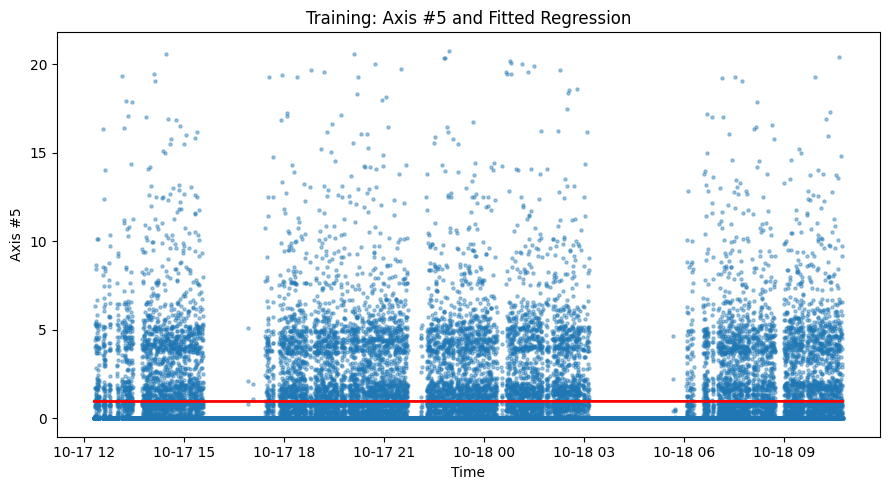

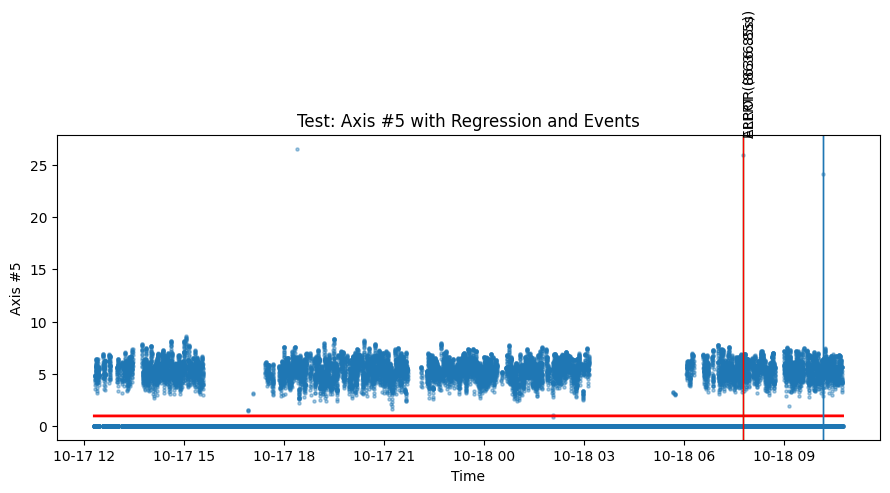

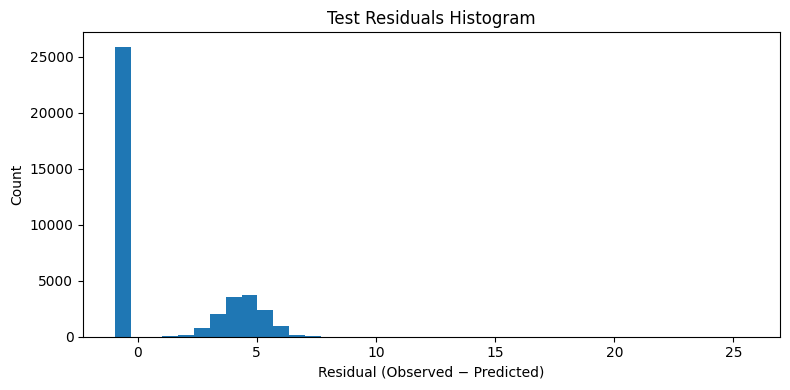

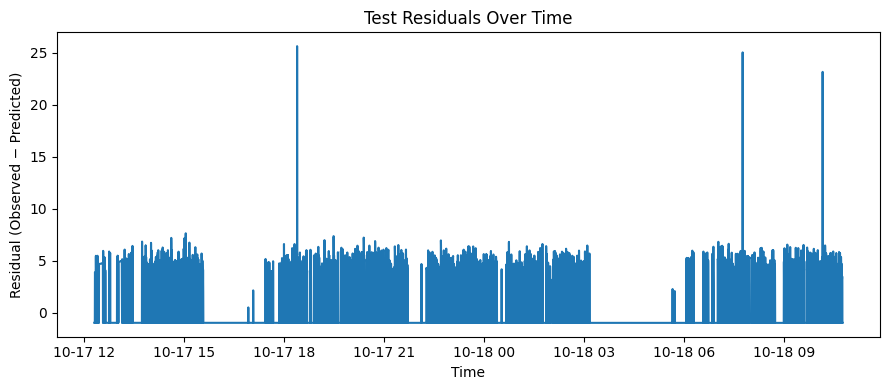

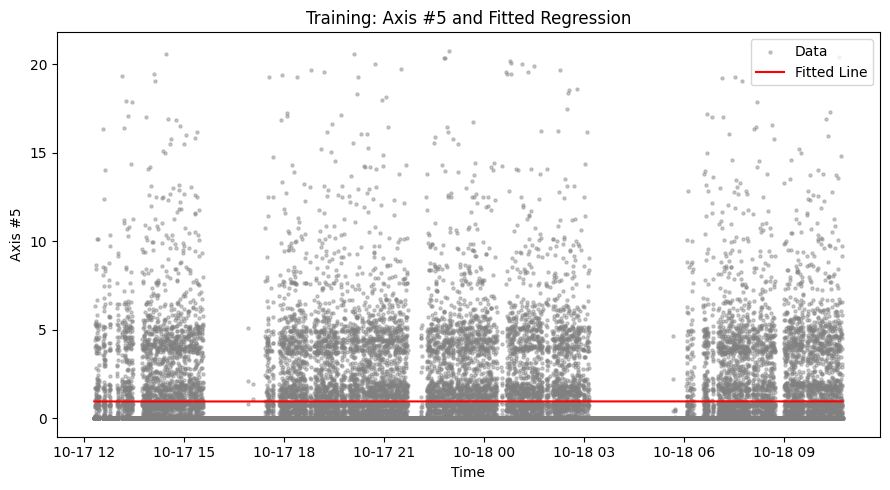

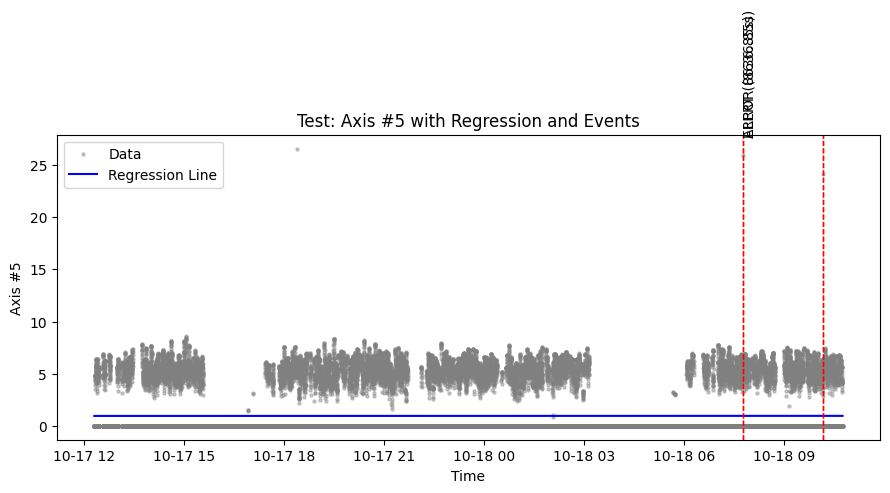

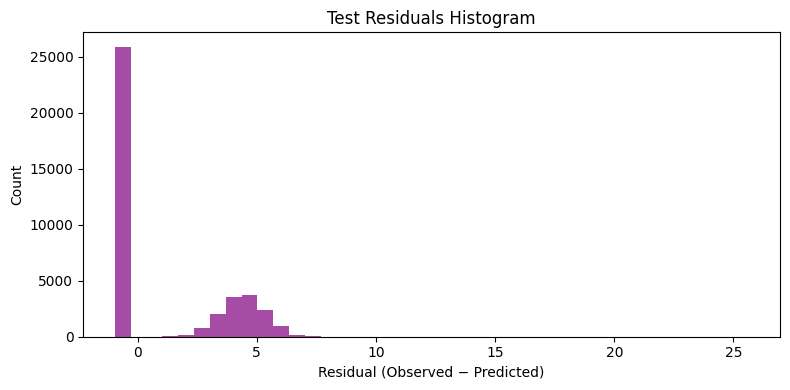

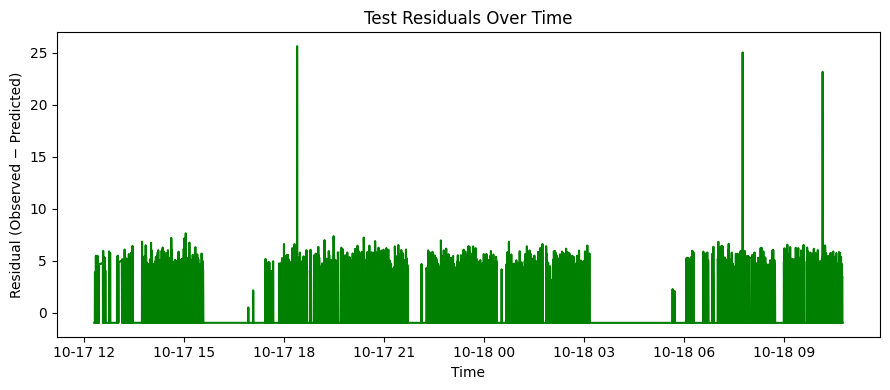

Updated events saved to logs/axis_events.csv


In [26]:
axis_name = 'Axis #5'

train_axis_with_time_df = load_axis_with_time(df_train, axis_name)
test_axis_with_time_df = load_axis_with_time(df_test, axis_name)


print('Train ' + axis_name + ' rows:', len(train_axis_with_time_df), ' Test rows:', len(test_axis1_with_time_df), '\n')
print('Train ' + axis_name + ' time range:', train_axis_with_time_df['Time'].min(), '→', train_axis_with_time_df['Time'].max())
print('Test ' + axis_name + ' time range:', test_axis1_with_time_df['Time'].min(),  '→', test_axis1_with_time_df['Time'].max())


train = train_axis_with_time_df.copy()
test  = test_axis_with_time_df.copy()

X_train = train[['t_sec']].values
y_train = train[axis_name].values

model = LinearRegression()
model.fit(X_train, y_train)

slope = float(model.coef_[0])
intercept = float(model.intercept_)
print('Slope:', slope)
print('Intercept:', intercept)

# Train residuals (for threshold derivation)
train['y_pred'] = model.predict(train[['t_sec']].values)
train['residual'] = train[axis_name] - train['y_pred']
train_pos = train[train['residual'] > 0].copy()

# Test residuals (for detection)
test['y_pred'] = model.predict(test[['t_sec']].values)
test['residual'] = test[axis_name] - test['y_pred']
test_pos = test[test['residual'] > 0].copy()

print('Train positive residuals:', len(train_pos), 'of', len(train))
print('Test  positive residuals:', len(test_pos),  'of', len(test))

train_pos_vals = train_pos['residual'].values

if len(train_pos_vals) == 0:
    # Fallback if no positive residuals in training
    minC_q = maxC_q = 0.0
    q_stats = (0, 0, 0)
    minC_s = maxC_s = 0.0
    s_stats = (0, 0)
else:
    minC_q, maxC_q, q_stats = threshold_quartile(train_pos_vals)
    minC_s, maxC_s, s_stats = threshold_std(train_pos_vals)

print('Quartile-based thresholds:')
print('  MinC_q =', minC_q, ' MaxC_q =', maxC_q, ' [q1, q3, IQR]=', q_stats)
print('Std-based thresholds:')
print('  MinC_s =', minC_s, ' MaxC_s =', maxC_s, ' [mean, std]=', s_stats)

# Choose which thresholds to use for detection
MinC = float(minC_q)
MaxC = float(maxC_q)
print('\nUsing quartile-based thresholds by default: MinC=', MinC, ' MaxC=', MaxC)

train_runs = detect_runs_above_threshold(train, MinC, grace_sec=2.0)
durations = [r['duration_sec'] for r in train_runs]
if len(durations) == 0:
    T = 2.0
else:
    T = max(2.0, float(np.percentile(durations, 95)))
    

print('Estimated T (sec):', T)


# Median dt from ALL training timestamps (sorted)
t_train = (train['Time'].astype('int64') // 10**9).values.astype(float)
dt_all = np.diff(t_train) if len(t_train) >= 2 else np.array([2.0])
median_dt = float(np.median(dt_all)) if len(dt_all) else 2.0

# Choose how many consecutive samples you require above threshold
N = 2  # we will try 2 first. we can raise to 5–10 for stricter persistence

# Final persistence time
T = max(2.0, N * median_dt)
print("Estimated T (sec):", T)



alerts, errors = detect_events(test, MinC, MaxC, T, grace_sec=2.0)
events_df = pd.DataFrame(alerts + errors, columns=[
    'event_id','level','start_time','end_time','duration_sec','peak_residual','mean_residual','area_above_baseline'
])


# prepend a column to events_df
events_df.insert(0, 'axis', axis_name)

print('Detected events:')
display(events_df.head(20))
print('Total Alerts:', len(alerts), ' Total Errors:', len(errors))


# 1) Training scatter and fitted line
plt.figure(figsize=(9,5))
plt.scatter(train['Time'], train[axis_name], s=5, alpha=0.4)
plt.plot(train['Time'], train['y_pred'], color='red', linewidth=2)
plt.title('Training: '+ axis_name +' and Fitted Regression')
plt.xlabel('Time')
plt.ylabel(axis_name)
plt.tight_layout()
plt.show()


# 2) Test scatter, regression line, and event markers with duration annotations
plt.figure(figsize=(9,5))
plt.scatter(test['Time'], test[axis_name], s=5, alpha=0.4)
plt.plot(test['Time'], test['y_pred'], color='red', linewidth=2)
plt.title('Test: ' + axis_name + ' with Regression and Events')
plt.xlabel('Time')
plt.ylabel(axis_name)

y_top = max(float(test[axis_name].max()), float(test['y_pred'].max()))
for ev in alerts + errors:
    plt.axvline(ev['start_time'], linewidth=1, color='green' if ev['level'] == 'ALERT' else 'red')
    plt.axvline(ev['end_time'], linewidth=1)
    dur = round(ev['duration_sec'], 2)
    plt.annotate(f"{ev['level']} ({dur}s)", xy=(ev['start_time'], y_top), xytext=(0, 10), textcoords='offset points', rotation=90)

plt.tight_layout()
plt.show()


# 3) Residual histogram (test)
plt.figure(figsize=(8,4))
plt.hist(test['residual'], bins=40)
plt.title('Test Residuals Histogram')
plt.xlabel('Residual (Observed − Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 4) Residual over time (test)
plt.figure(figsize=(9,4))
plt.plot(test['Time'], test['residual'])
plt.title('Test Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Observed − Predicted)')
plt.tight_layout()
plt.show()



# 1) Training scatter and fitted line
plt.figure(figsize=(9,5))
plt.scatter(train['Time'], train[axis_name], s=5, alpha=0.4, color='gray', label='Data')
plt.plot(train['Time'], train['y_pred'], color='red', label='Fitted Line')
plt.title('Training: '+ axis_name +' and Fitted Regression')
plt.xlabel('Time')
plt.ylabel(axis_name)
plt.legend()
plt.tight_layout()
plt.show()


# 2) Test scatter, regression line, and event markers with duration annotations
plt.figure(figsize=(9,5))
plt.scatter(test['Time'], test[axis_name], s=5, alpha=0.4, color='gray', label='Data')
plt.plot(test['Time'], test['y_pred'], color='blue', label='Regression Line')
plt.title('Test: ' + axis_name + ' with Regression and Events')
plt.xlabel('Time')
plt.ylabel(axis_name)

y_top = max(float(test[axis_name].max()), float(test['y_pred'].max()))
for ev in alerts + errors:
    if ev['level'] == 'alert':
        line_color = 'orange'
    else:
        line_color = 'red'
    plt.axvline(ev['start_time'], linewidth=1, color=line_color, linestyle='--')
    plt.axvline(ev['end_time'], linewidth=1, color=line_color, linestyle='--')
    dur = round(ev['duration_sec'], 2)
    plt.annotate(f"{ev['level']} ({dur}s)", xy=(ev['start_time'], y_top), 
                 xytext=(0, 10), textcoords='offset points', rotation=90)

plt.legend()
plt.tight_layout()
plt.show()

# 3) Residual histogram (test)
plt.figure(figsize=(8,4))
plt.hist(test['residual'], bins=40, color='purple', alpha=0.7)
plt.title('Test Residuals Histogram')
plt.xlabel('Residual (Observed − Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# 4) Residual over time (test)
plt.figure(figsize=(9,4))
plt.plot(test['Time'], test['residual'], color='green')
plt.title('Test Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Observed − Predicted)')
plt.tight_layout()
plt.show()


# load the events CSV file and append the values of events_df to it
existing_events_df = pd.read_csv(EVENTS_CSV)
combined_events_df = pd.concat([existing_events_df, events_df], ignore_index=True)
combined_events_df.to_csv(EVENTS_CSV, index=False)
print('Updated events saved to', EVENTS_CSV)

Train Axis #6 rows: 39672  Test rows: 39672 

Train Axis #6 time range: 2022-10-17 12:18:23.660000+00:00 → 2022-10-18 10:44:58.628000+00:00
Test Axis #6 time range: 2022-10-17 12:18:23.660000+00:00 → 2022-10-18 10:44:58.628000+00:00
Slope: 4.744433715386859e-07
Intercept: -789.8468984671692
Train positive residuals: 8200 of 39672
Test  positive residuals: 9409 of 39672
Quartile-based thresholds:
  MinC_q = 5.530906750811832  MaxC_q = 8.711232570065894  [q1, q3, IQR]= (np.float64(0.230363718721729), np.float64(2.35058093155777), np.float64(2.120217212836041))
Std-based thresholds:
  MinC_s = 8.513025622442028  MaxC_s = 11.708704638411165  [mean, std]= (np.float64(2.1216675905037525), np.float64(3.1956790159691373))

Using quartile-based thresholds by default: MinC= 5.530906750811832  MaxC= 8.711232570065894
Estimated T (sec): 59.002999999999986
Estimated T (sec): 4.0
seg                                   Time         t_sec    Axis #6    y_pred  \
25300 2022-10-18 02:42:32.874000+00:00  

C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))
C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))


axis event_id  level                       start_time  \
0  Axis #6    A0001  ALERT 2022-10-18 02:42:32.874000+00:00   
1  Axis #6    E0001  ERROR 2022-10-18 02:42:32.874000+00:00   

                          end_time  duration_sec  peak_residual  \
0 2022-10-18 10:09:02.627000+00:00     26789.753      21.172377   
1 2022-10-18 10:09:02.627000+00:00     26789.753      21.172377   

   mean_residual  area_above_baseline  
0       0.706423         20668.283432  
1       0.706423         20668.283432

Total Alerts: 1  Total Errors: 1


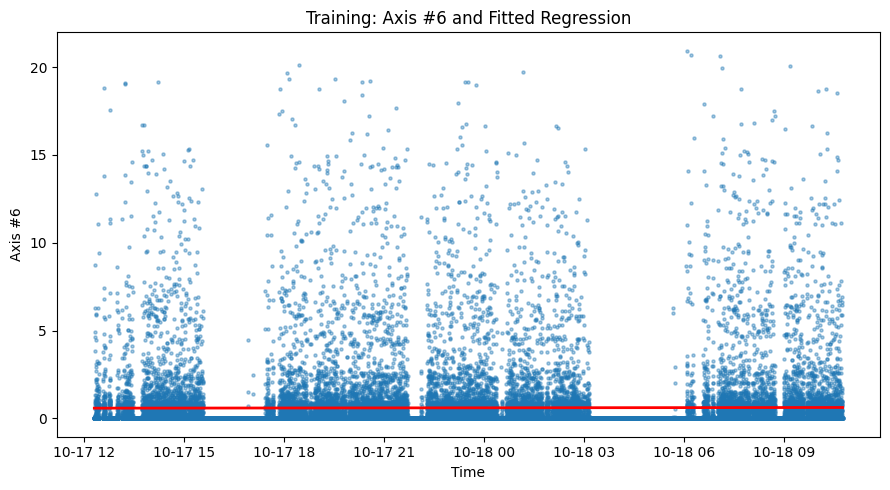

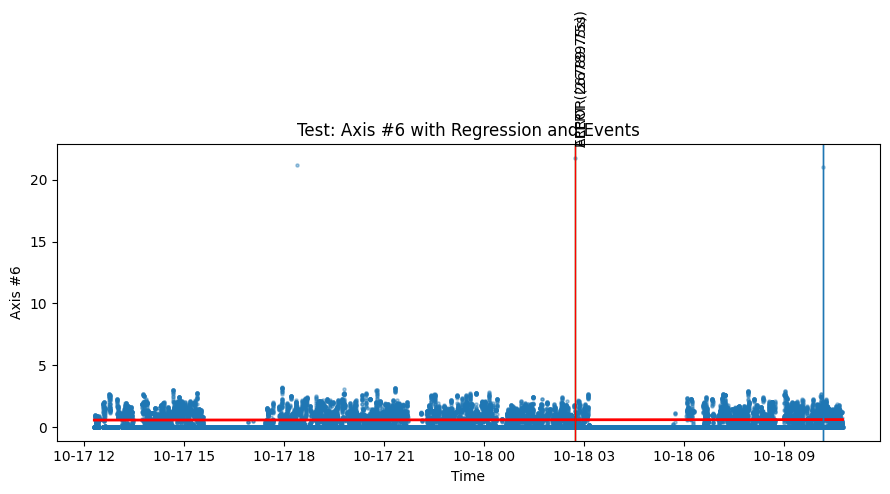

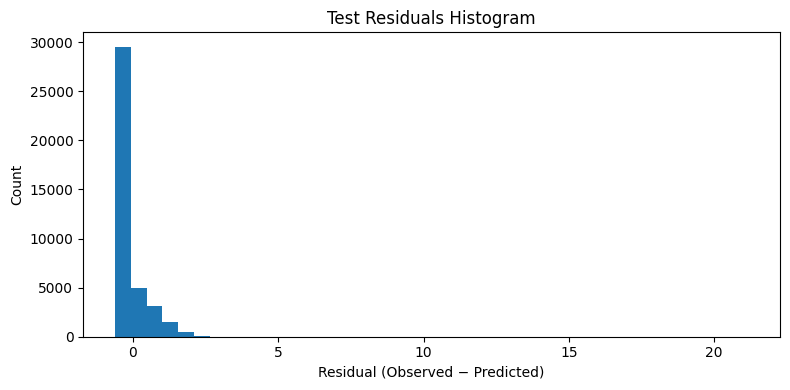

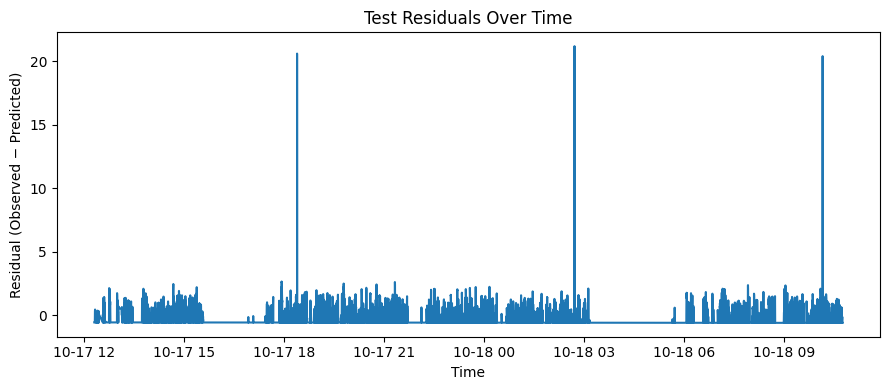

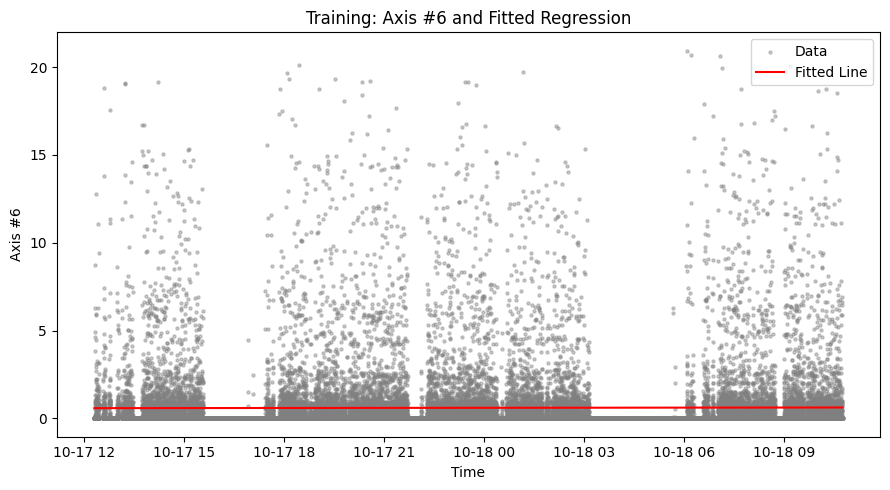

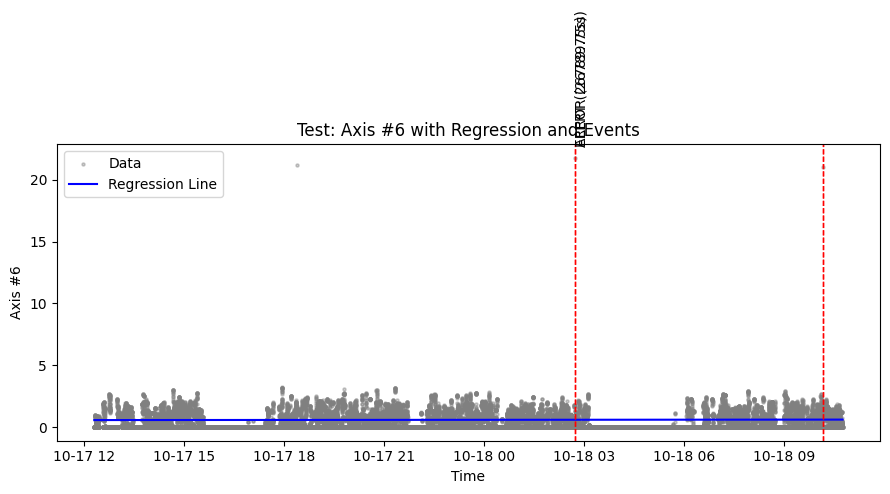

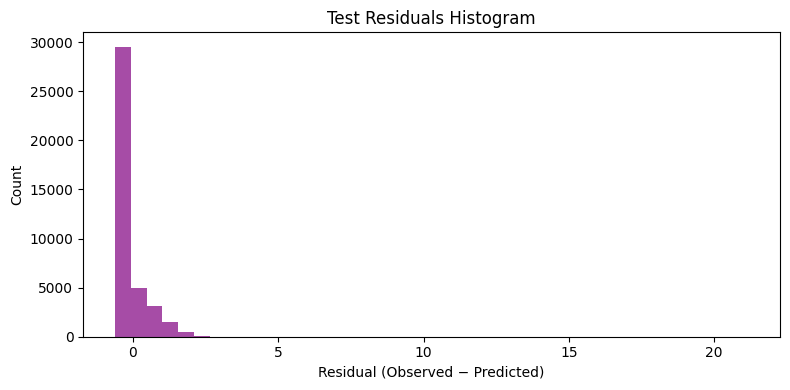

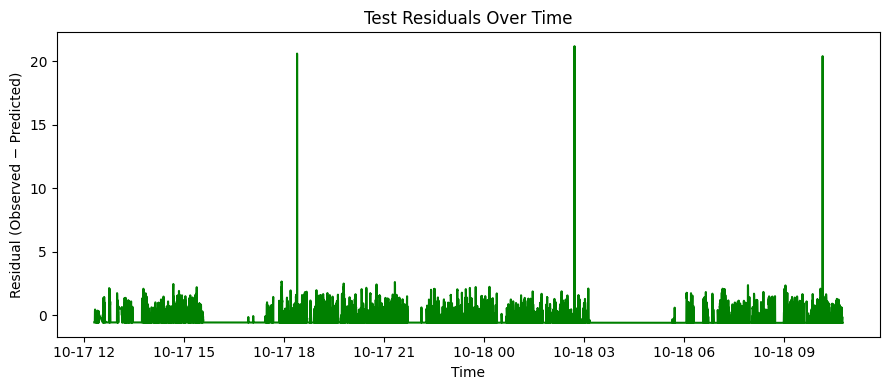

Updated events saved to logs/axis_events.csv


In [27]:
axis_name = 'Axis #6'

train_axis_with_time_df = load_axis_with_time(df_train, axis_name)
test_axis_with_time_df = load_axis_with_time(df_test, axis_name)


print('Train ' + axis_name + ' rows:', len(train_axis_with_time_df), ' Test rows:', len(test_axis1_with_time_df), '\n')
print('Train ' + axis_name + ' time range:', train_axis_with_time_df['Time'].min(), '→', train_axis_with_time_df['Time'].max())
print('Test ' + axis_name + ' time range:', test_axis1_with_time_df['Time'].min(),  '→', test_axis1_with_time_df['Time'].max())


train = train_axis_with_time_df.copy()
test  = test_axis_with_time_df.copy()

X_train = train[['t_sec']].values
y_train = train[axis_name].values

model = LinearRegression()
model.fit(X_train, y_train)

slope = float(model.coef_[0])
intercept = float(model.intercept_)
print('Slope:', slope)
print('Intercept:', intercept)

# Train residuals (for threshold derivation)
train['y_pred'] = model.predict(train[['t_sec']].values)
train['residual'] = train[axis_name] - train['y_pred']
train_pos = train[train['residual'] > 0].copy()

# Test residuals (for detection)
test['y_pred'] = model.predict(test[['t_sec']].values)
test['residual'] = test[axis_name] - test['y_pred']
test_pos = test[test['residual'] > 0].copy()

print('Train positive residuals:', len(train_pos), 'of', len(train))
print('Test  positive residuals:', len(test_pos),  'of', len(test))

train_pos_vals = train_pos['residual'].values

if len(train_pos_vals) == 0:
    # Fallback if no positive residuals in training
    minC_q = maxC_q = 0.0
    q_stats = (0, 0, 0)
    minC_s = maxC_s = 0.0
    s_stats = (0, 0)
else:
    minC_q, maxC_q, q_stats = threshold_quartile(train_pos_vals)
    minC_s, maxC_s, s_stats = threshold_std(train_pos_vals)

print('Quartile-based thresholds:')
print('  MinC_q =', minC_q, ' MaxC_q =', maxC_q, ' [q1, q3, IQR]=', q_stats)
print('Std-based thresholds:')
print('  MinC_s =', minC_s, ' MaxC_s =', maxC_s, ' [mean, std]=', s_stats)

# Choose which thresholds to use for detection
MinC = float(minC_q)
MaxC = float(maxC_q)
print('\nUsing quartile-based thresholds by default: MinC=', MinC, ' MaxC=', MaxC)

train_runs = detect_runs_above_threshold(train, MinC, grace_sec=2.0)
durations = [r['duration_sec'] for r in train_runs]
if len(durations) == 0:
    T = 2.0
else:
    T = max(2.0, float(np.percentile(durations, 95)))
    

print('Estimated T (sec):', T)


# Median dt from ALL training timestamps (sorted)
t_train = (train['Time'].astype('int64') // 10**9).values.astype(float)
dt_all = np.diff(t_train) if len(t_train) >= 2 else np.array([2.0])
median_dt = float(np.median(dt_all)) if len(dt_all) else 2.0

# Choose how many consecutive samples you require above threshold
N = 2  # we will try 2 first. we can raise to 5–10 for stricter persistence

# Final persistence time
T = max(2.0, N * median_dt)
print("Estimated T (sec):", T)



alerts, errors = detect_events(test, MinC, MaxC, T, grace_sec=2.0)
events_df = pd.DataFrame(alerts + errors, columns=[
    'event_id','level','start_time','end_time','duration_sec','peak_residual','mean_residual','area_above_baseline'
])


# prepend a column to events_df
events_df.insert(0, 'axis', axis_name)

print('Detected events:')
display(events_df.head(20))
print('Total Alerts:', len(alerts), ' Total Errors:', len(errors))


# 1) Training scatter and fitted line
plt.figure(figsize=(9,5))
plt.scatter(train['Time'], train[axis_name], s=5, alpha=0.4)
plt.plot(train['Time'], train['y_pred'], color='red', linewidth=2)
plt.title('Training: '+ axis_name +' and Fitted Regression')
plt.xlabel('Time')
plt.ylabel(axis_name)
plt.tight_layout()
plt.show()


# 2) Test scatter, regression line, and event markers with duration annotations
plt.figure(figsize=(9,5))
plt.scatter(test['Time'], test[axis_name], s=5, alpha=0.4)
plt.plot(test['Time'], test['y_pred'], color='red', linewidth=2)
plt.title('Test: ' + axis_name + ' with Regression and Events')
plt.xlabel('Time')
plt.ylabel(axis_name)

y_top = max(float(test[axis_name].max()), float(test['y_pred'].max()))
for ev in alerts + errors:
    plt.axvline(ev['start_time'], linewidth=1, color='green' if ev['level'] == 'ALERT' else 'red')
    plt.axvline(ev['end_time'], linewidth=1)
    dur = round(ev['duration_sec'], 2)
    plt.annotate(f"{ev['level']} ({dur}s)", xy=(ev['start_time'], y_top), xytext=(0, 10), textcoords='offset points', rotation=90)

plt.tight_layout()
plt.show()


# 3) Residual histogram (test)
plt.figure(figsize=(8,4))
plt.hist(test['residual'], bins=40)
plt.title('Test Residuals Histogram')
plt.xlabel('Residual (Observed − Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 4) Residual over time (test)
plt.figure(figsize=(9,4))
plt.plot(test['Time'], test['residual'])
plt.title('Test Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Observed − Predicted)')
plt.tight_layout()
plt.show()



# 1) Training scatter and fitted line
plt.figure(figsize=(9,5))
plt.scatter(train['Time'], train[axis_name], s=5, alpha=0.4, color='gray', label='Data')
plt.plot(train['Time'], train['y_pred'], color='red', label='Fitted Line')
plt.title('Training: '+ axis_name +' and Fitted Regression')
plt.xlabel('Time')
plt.ylabel(axis_name)
plt.legend()
plt.tight_layout()
plt.show()


# 2) Test scatter, regression line, and event markers with duration annotations
plt.figure(figsize=(9,5))
plt.scatter(test['Time'], test[axis_name], s=5, alpha=0.4, color='gray', label='Data')
plt.plot(test['Time'], test['y_pred'], color='blue', label='Regression Line')
plt.title('Test: ' + axis_name + ' with Regression and Events')
plt.xlabel('Time')
plt.ylabel(axis_name)

y_top = max(float(test[axis_name].max()), float(test['y_pred'].max()))
for ev in alerts + errors:
    if ev['level'] == 'alert':
        line_color = 'orange'
    else:
        line_color = 'red'
    plt.axvline(ev['start_time'], linewidth=1, color=line_color, linestyle='--')
    plt.axvline(ev['end_time'], linewidth=1, color=line_color, linestyle='--')
    dur = round(ev['duration_sec'], 2)
    plt.annotate(f"{ev['level']} ({dur}s)", xy=(ev['start_time'], y_top), 
                 xytext=(0, 10), textcoords='offset points', rotation=90)

plt.legend()
plt.tight_layout()
plt.show()

# 3) Residual histogram (test)
plt.figure(figsize=(8,4))
plt.hist(test['residual'], bins=40, color='purple', alpha=0.7)
plt.title('Test Residuals Histogram')
plt.xlabel('Residual (Observed − Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# 4) Residual over time (test)
plt.figure(figsize=(9,4))
plt.plot(test['Time'], test['residual'], color='green')
plt.title('Test Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Observed − Predicted)')
plt.tight_layout()
plt.show()


# load the events CSV file and append the values of events_df to it
existing_events_df = pd.read_csv(EVENTS_CSV)
combined_events_df = pd.concat([existing_events_df, events_df], ignore_index=True)
combined_events_df.to_csv(EVENTS_CSV, index=False)
print('Updated events saved to', EVENTS_CSV)

Train Axis #7 rows: 39672  Test rows: 39672 

Train Axis #7 time range: 2022-10-17 12:18:23.660000+00:00 → 2022-10-18 10:44:58.628000+00:00
Test Axis #7 time range: 2022-10-17 12:18:23.660000+00:00 → 2022-10-18 10:44:58.628000+00:00
Slope: 5.537143214194605e-07
Intercept: -921.6455372315062
Train positive residuals: 6365 of 39672
Test  positive residuals: 13509 of 39672
Quartile-based thresholds:
  MinC_q = 16.479451714619167  MaxC_q = 25.76994016367312  [q1, q3, IQR]= (np.float64(0.9953042995292523), np.float64(7.188963265565219), np.float64(6.193658966035967))
Std-based thresholds:
  MinC_s = 9.98803725136382  MaxC_s = 12.903205935208405  [mean, std]= (np.float64(4.157699883674649), np.float64(2.9151686838445854))

Using quartile-based thresholds by default: MinC= 16.479451714619167  MaxC= 25.76994016367312
Estimated T (sec): 2.0
Estimated T (sec): 4.0
seg                                   Time         t_sec    Axis #7    y_pred  \
25293 2022-10-18 02:42:19.551000+00:00  1.666061e+09

C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))


axis event_id  level                       start_time  \
0  Axis #7    A0001  ALERT 2022-10-18 02:42:19.551000+00:00   

                          end_time  duration_sec  peak_residual  \
0 2022-10-18 07:45:19.009000+00:00     18179.458      21.270267   

   mean_residual  area_above_baseline  
0       1.180081          10249.21455

Total Alerts: 1  Total Errors: 0


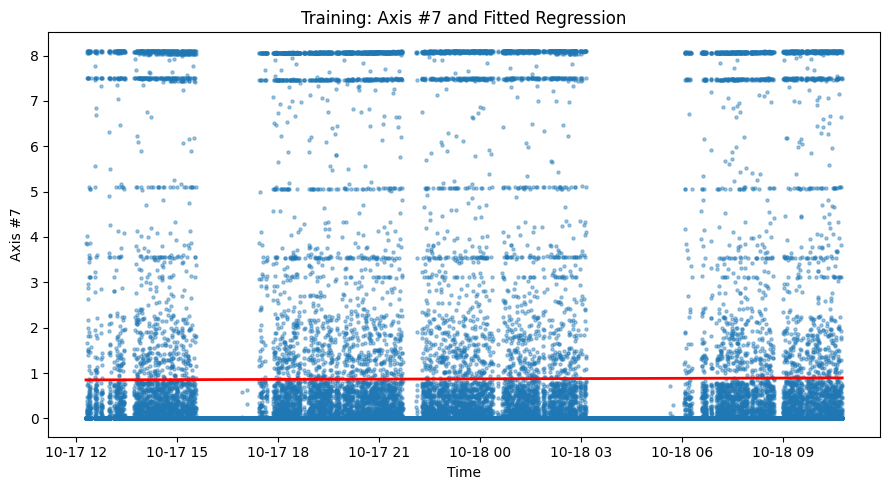

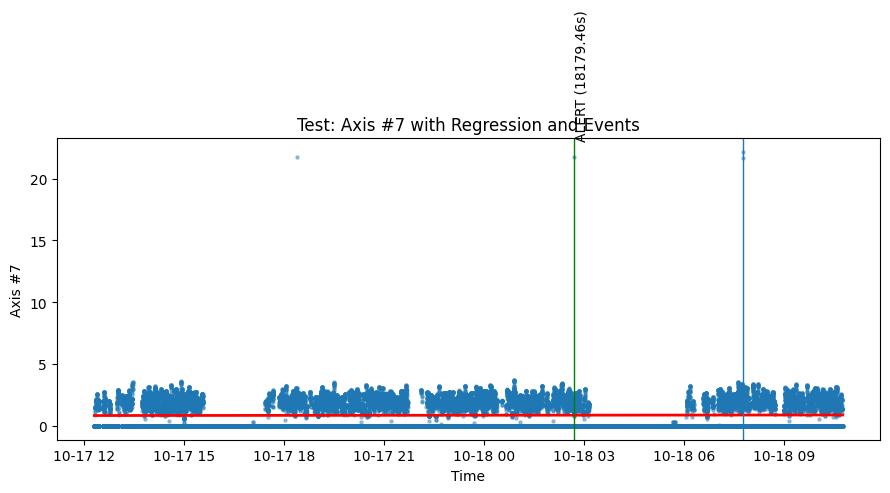

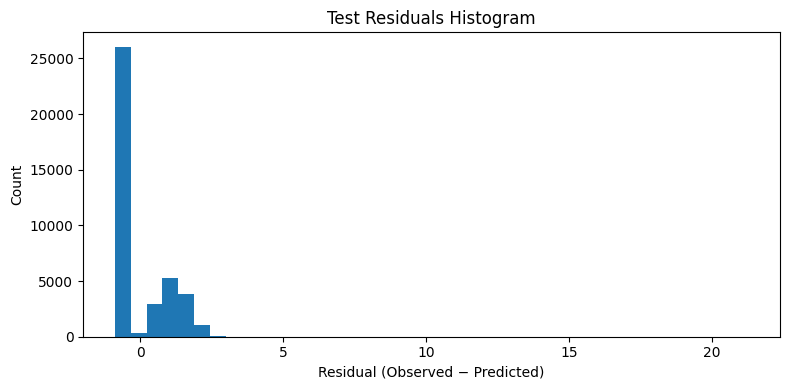

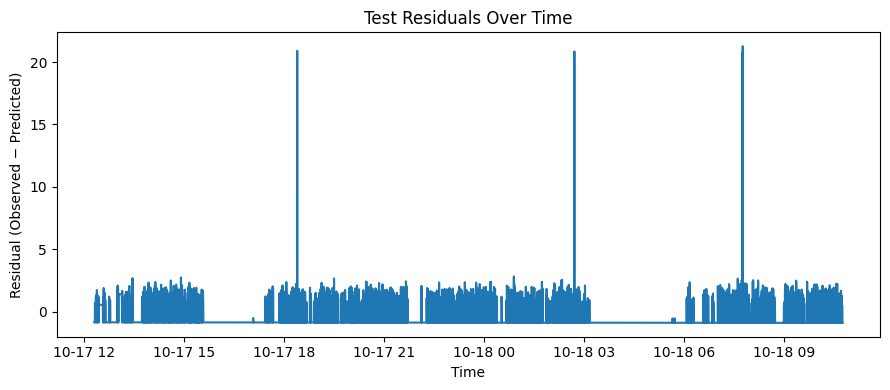

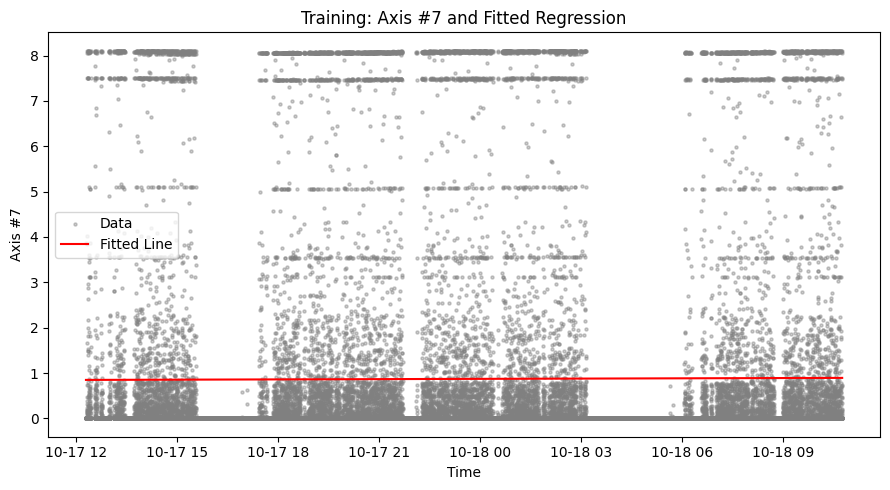

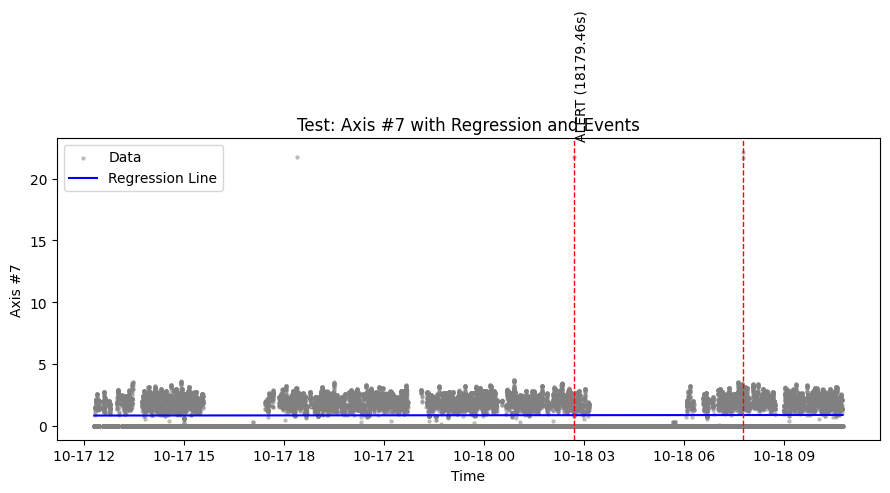

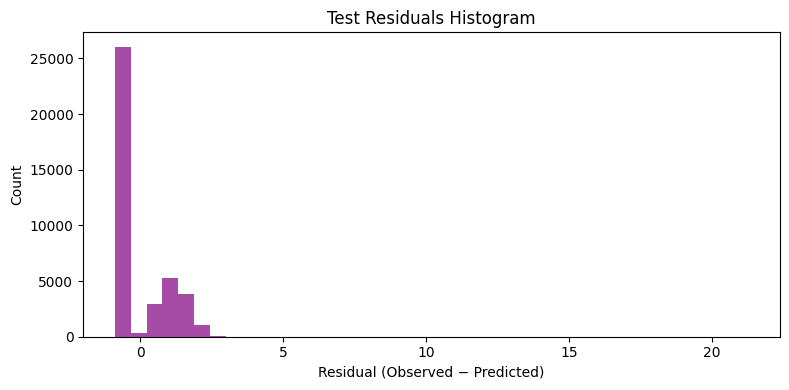

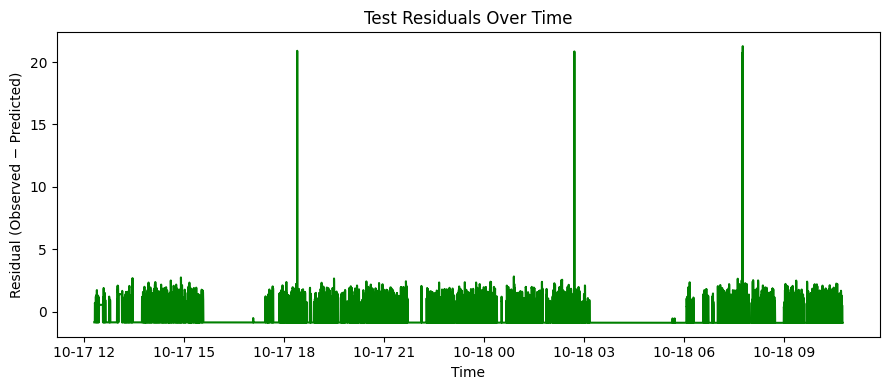

Updated events saved to logs/axis_events.csv


In [28]:
axis_name = 'Axis #7'

train_axis_with_time_df = load_axis_with_time(df_train, axis_name)
test_axis_with_time_df = load_axis_with_time(df_test, axis_name)


print('Train ' + axis_name + ' rows:', len(train_axis_with_time_df), ' Test rows:', len(test_axis1_with_time_df), '\n')
print('Train ' + axis_name + ' time range:', train_axis_with_time_df['Time'].min(), '→', train_axis_with_time_df['Time'].max())
print('Test ' + axis_name + ' time range:', test_axis1_with_time_df['Time'].min(),  '→', test_axis1_with_time_df['Time'].max())


train = train_axis_with_time_df.copy()
test  = test_axis_with_time_df.copy()

X_train = train[['t_sec']].values
y_train = train[axis_name].values

model = LinearRegression()
model.fit(X_train, y_train)

slope = float(model.coef_[0])
intercept = float(model.intercept_)
print('Slope:', slope)
print('Intercept:', intercept)

# Train residuals (for threshold derivation)
train['y_pred'] = model.predict(train[['t_sec']].values)
train['residual'] = train[axis_name] - train['y_pred']
train_pos = train[train['residual'] > 0].copy()

# Test residuals (for detection)
test['y_pred'] = model.predict(test[['t_sec']].values)
test['residual'] = test[axis_name] - test['y_pred']
test_pos = test[test['residual'] > 0].copy()

print('Train positive residuals:', len(train_pos), 'of', len(train))
print('Test  positive residuals:', len(test_pos),  'of', len(test))

train_pos_vals = train_pos['residual'].values

if len(train_pos_vals) == 0:
    # Fallback if no positive residuals in training
    minC_q = maxC_q = 0.0
    q_stats = (0, 0, 0)
    minC_s = maxC_s = 0.0
    s_stats = (0, 0)
else:
    minC_q, maxC_q, q_stats = threshold_quartile(train_pos_vals)
    minC_s, maxC_s, s_stats = threshold_std(train_pos_vals)

print('Quartile-based thresholds:')
print('  MinC_q =', minC_q, ' MaxC_q =', maxC_q, ' [q1, q3, IQR]=', q_stats)
print('Std-based thresholds:')
print('  MinC_s =', minC_s, ' MaxC_s =', maxC_s, ' [mean, std]=', s_stats)

# Choose which thresholds to use for detection
MinC = float(minC_q)
MaxC = float(maxC_q)
print('\nUsing quartile-based thresholds by default: MinC=', MinC, ' MaxC=', MaxC)

train_runs = detect_runs_above_threshold(train, MinC, grace_sec=2.0)
durations = [r['duration_sec'] for r in train_runs]
if len(durations) == 0:
    T = 2.0
else:
    T = max(2.0, float(np.percentile(durations, 95)))
    

print('Estimated T (sec):', T)


# Median dt from ALL training timestamps (sorted)
t_train = (train['Time'].astype('int64') // 10**9).values.astype(float)
dt_all = np.diff(t_train) if len(t_train) >= 2 else np.array([2.0])
median_dt = float(np.median(dt_all)) if len(dt_all) else 2.0

# Choose how many consecutive samples you require above threshold
N = 2  # we will try 2 first. we can raise to 5–10 for stricter persistence

# Final persistence time
T = max(2.0, N * median_dt)
print("Estimated T (sec):", T)



alerts, errors = detect_events(test, MinC, MaxC, T, grace_sec=2.0)
events_df = pd.DataFrame(alerts + errors, columns=[
    'event_id','level','start_time','end_time','duration_sec','peak_residual','mean_residual','area_above_baseline'
])


# prepend a column to events_df
events_df.insert(0, 'axis', axis_name)

print('Detected events:')
display(events_df.head(20))
print('Total Alerts:', len(alerts), ' Total Errors:', len(errors))


# 1) Training scatter and fitted line
plt.figure(figsize=(9,5))
plt.scatter(train['Time'], train[axis_name], s=5, alpha=0.4)
plt.plot(train['Time'], train['y_pred'], color='red', linewidth=2)
plt.title('Training: '+ axis_name +' and Fitted Regression')
plt.xlabel('Time')
plt.ylabel(axis_name)
plt.tight_layout()
plt.show()


# 2) Test scatter, regression line, and event markers with duration annotations
plt.figure(figsize=(9,5))
plt.scatter(test['Time'], test[axis_name], s=5, alpha=0.4)
plt.plot(test['Time'], test['y_pred'], color='red', linewidth=2)
plt.title('Test: ' + axis_name + ' with Regression and Events')
plt.xlabel('Time')
plt.ylabel(axis_name)

y_top = max(float(test[axis_name].max()), float(test['y_pred'].max()))
for ev in alerts + errors:
    plt.axvline(ev['start_time'], linewidth=1, color='green' if ev['level'] == 'ALERT' else 'red')
    plt.axvline(ev['end_time'], linewidth=1)
    dur = round(ev['duration_sec'], 2)
    plt.annotate(f"{ev['level']} ({dur}s)", xy=(ev['start_time'], y_top), xytext=(0, 10), textcoords='offset points', rotation=90)

plt.tight_layout()
plt.show()


# 3) Residual histogram (test)
plt.figure(figsize=(8,4))
plt.hist(test['residual'], bins=40)
plt.title('Test Residuals Histogram')
plt.xlabel('Residual (Observed − Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 4) Residual over time (test)
plt.figure(figsize=(9,4))
plt.plot(test['Time'], test['residual'])
plt.title('Test Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Observed − Predicted)')
plt.tight_layout()
plt.show()



# 1) Training scatter and fitted line
plt.figure(figsize=(9,5))
plt.scatter(train['Time'], train[axis_name], s=5, alpha=0.4, color='gray', label='Data')
plt.plot(train['Time'], train['y_pred'], color='red', label='Fitted Line')
plt.title('Training: '+ axis_name +' and Fitted Regression')
plt.xlabel('Time')
plt.ylabel(axis_name)
plt.legend()
plt.tight_layout()
plt.show()


# 2) Test scatter, regression line, and event markers with duration annotations
plt.figure(figsize=(9,5))
plt.scatter(test['Time'], test[axis_name], s=5, alpha=0.4, color='gray', label='Data')
plt.plot(test['Time'], test['y_pred'], color='blue', label='Regression Line')
plt.title('Test: ' + axis_name + ' with Regression and Events')
plt.xlabel('Time')
plt.ylabel(axis_name)

y_top = max(float(test[axis_name].max()), float(test['y_pred'].max()))
for ev in alerts + errors:
    if ev['level'] == 'alert':
        line_color = 'orange'
    else:
        line_color = 'red'
    plt.axvline(ev['start_time'], linewidth=1, color=line_color, linestyle='--')
    plt.axvline(ev['end_time'], linewidth=1, color=line_color, linestyle='--')
    dur = round(ev['duration_sec'], 2)
    plt.annotate(f"{ev['level']} ({dur}s)", xy=(ev['start_time'], y_top), 
                 xytext=(0, 10), textcoords='offset points', rotation=90)

plt.legend()
plt.tight_layout()
plt.show()

# 3) Residual histogram (test)
plt.figure(figsize=(8,4))
plt.hist(test['residual'], bins=40, color='purple', alpha=0.7)
plt.title('Test Residuals Histogram')
plt.xlabel('Residual (Observed − Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# 4) Residual over time (test)
plt.figure(figsize=(9,4))
plt.plot(test['Time'], test['residual'], color='green')
plt.title('Test Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Observed − Predicted)')
plt.tight_layout()
plt.show()


# load the events CSV file and append the values of events_df to it
existing_events_df = pd.read_csv(EVENTS_CSV)
combined_events_df = pd.concat([existing_events_df, events_df], ignore_index=True)
combined_events_df.to_csv(EVENTS_CSV, index=False)
print('Updated events saved to', EVENTS_CSV)

Train Axis #8 rows: 39672  Test rows: 39672 

Train Axis #8 time range: 2022-10-17 12:18:23.660000+00:00 → 2022-10-18 10:44:58.628000+00:00
Test Axis #8 time range: 2022-10-17 12:18:23.660000+00:00 → 2022-10-18 10:44:58.628000+00:00
Slope: 8.499833330258342e-08
Intercept: -141.50924910947344
Train positive residuals: 5924 of 39672
Test  positive residuals: 10134 of 39672
Quartile-based thresholds:
  MinC_q = 0.35485089341601456  MaxC_q = 0.5575132234341085  [q1, q3, IQR]= (np.float64(0.017080343385858135), np.float64(0.1521885633979207), np.float64(0.13510822001206257))
Std-based thresholds:
  MinC_s = 2.3997227917468673  MaxC_s = 3.3599568461032376  [mean, std]= (np.float64(0.4792546830341264), np.float64(0.9602340543563705))

Using quartile-based thresholds by default: MinC= 0.35485089341601456  MaxC= 0.5575132234341085
Estimated T (sec): 206.90970000000002
Estimated T (sec): 4.0
seg                                  Time         t_sec   Axis #8    y_pred  \
1045 2022-10-17 13:00:10.9

C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))
C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))
C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))
C:\Users\lopez\AppData\Local\Temp\ipykernel_16016\3201252518.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(rvals, tsec))
C:\Users\lopez\AppData\Local\Tem

axis event_id  level                       start_time  \
0   Axis #8    A0001  ALERT 2022-10-17 13:00:10.949000+00:00   
1   Axis #8    A0002  ALERT 2022-10-17 13:26:03.721000+00:00   
2   Axis #8    A0003  ALERT 2022-10-17 13:26:45.544000+00:00   
3   Axis #8    A0004  ALERT 2022-10-17 14:33:15.063000+00:00   
4   Axis #8    A0005  ALERT 2022-10-17 14:47:19.098000+00:00   
5   Axis #8    A0006  ALERT 2022-10-17 14:48:08.479000+00:00   
6   Axis #8    A0007  ALERT 2022-10-17 14:48:20.299000+00:00   
7   Axis #8    A0008  ALERT 2022-10-17 14:48:48.642000+00:00   
8   Axis #8    A0009  ALERT 2022-10-17 14:52:23.499000+00:00   
9   Axis #8    A0010  ALERT 2022-10-17 14:52:38.718000+00:00   
10  Axis #8    A0011  ALERT 2022-10-17 14:56:22.426000+00:00   
11  Axis #8    A0012  ALERT 2022-10-17 15:27:16.565000+00:00   
12  Axis #8    A0013  ALERT 2022-10-17 17:54:21.198000+00:00   
13  Axis #8    A0014  ALERT 2022-10-17 17:54:42.447000+00:00   
14  Axis #8    A0015  ALERT 2022-10-17 17:56:59.122000+00:00   
15  Axis #8    A0016  ALERT 2022-10-17 17:58:38.404000+00:00   
16  Axis #8    A0017  ALERT 2022-10-17 18:05:40.072000+00:00   
17  Axis #8    A0018  ALERT 2022-10-17 18:09:15.215000+00:00   
18  Axis #8    A0019  ALERT 2022-10-17 18:10:56.077000+00:00   
19  Axis #8    A0020  ALERT 2022-10-17 18:13:04.952000+00:00   

                           end_time  duration_sec  peak_residual  \
0  2022-10-17 13:00:30.212000+00:00        19.263       0.390145   
1  2022-10-17 13:26:22.965000+00:00        19.244       0.629098   
2  2022-10-17 13:27:16.189000+00:00        30.645       0.575986   
3  2022-10-17 14:33:34.209000+00:00        19.146       0.474549   
4  2022-10-17 14:47:24.754000+00:00         5.656       0.377809   
5  2022-10-17 14:48:14.322000+00:00         5.843       0.395147   
6  2022-10-17 14:48:27.956000+00:00         7.657       0.457358   
7  2022-10-17 14:49:08.026000+00:00        19.384       0.468722   
8  2022-10-17 14:52:33.127000+00:00         9.628       0.481448   
9  2022-10-17 14:52:50.187000+00:00        11.469       0.513278   
10 2022-10-17 14:56:28.334000+00:00         5.908       0.375432   
11 2022-10-17 15:27:30.121000+00:00        13.556       0.435515   
12 2022-10-17 17:54:36.582000+00:00        15.384       0.496026   
13 2022-10-17 17:54:48.291000+00:00         5.844       0.497988   
14 2022-10-17 17:57:22.173000+00:00        23.051       0.419523   
15 2022-10-17 17:58:55.842000+00:00        17.438       0.497423   
16 2022-10-17 18:05:57.229000+00:00        17.157       0.413518   
17 2022-10-17 18:09:42.075000+00:00        26.860       0.498971   
18 2022-10-17 18:11:01.817000+00:00         5.740       0.436604   
19 2022-10-17 18:13:31.707000+00:00        26.755       0.540623   

    mean_residual  area_above_baseline  
0        0.374823             7.496768  
1        0.567514            10.768382  
2        0.467062            14.405722  
3        0.470849             8.953915  
4        0.367940             1.854023  
5        0.375828             2.254435  
6        0.420669             2.907924  
7        0.417282             8.418376  
8        0.431920             4.336808  
9        0.505264             6.077119  
10       0.368777             2.219486  
11       0.404989             5.705462  
12       0.445651             6.717451  
13       0.489552             2.944985  
14       0.393176             9.038185  
15       0.451947             7.713865  
16       0.390094             6.706317  
17       0.446998            12.189818  
18       0.423456             2.134844  
19       0.461439            12.609521

Total Alerts: 69  Total Errors: 3


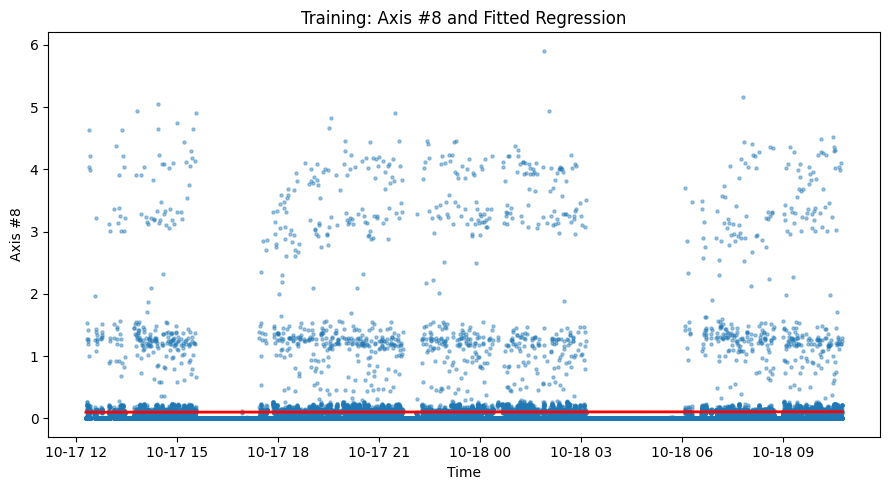

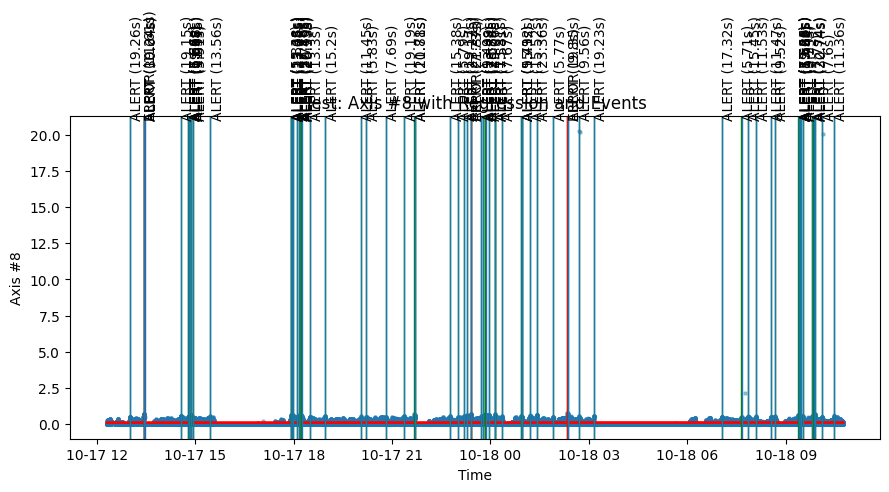

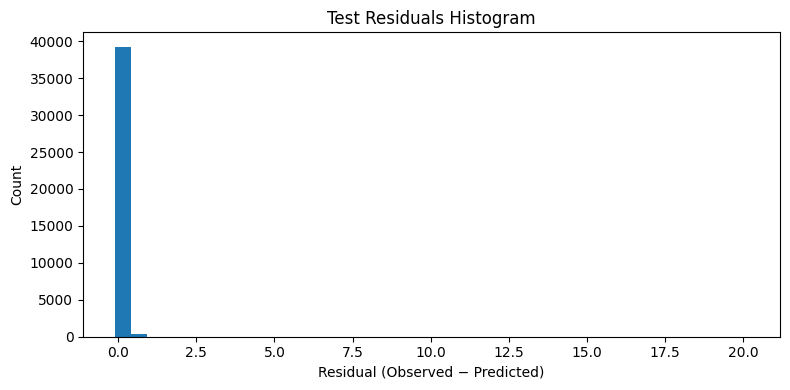

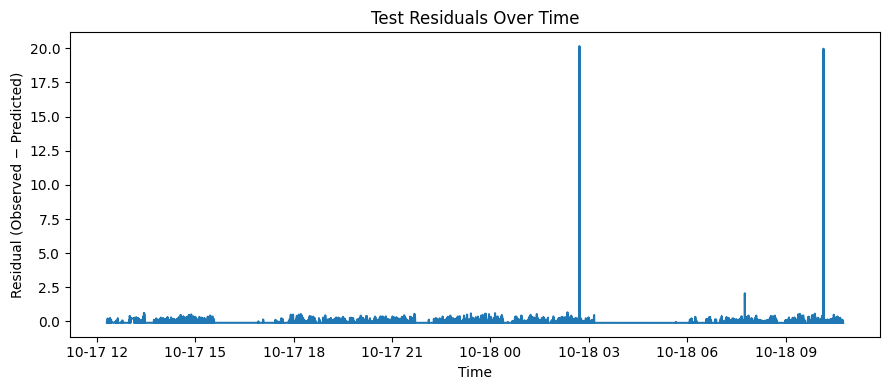

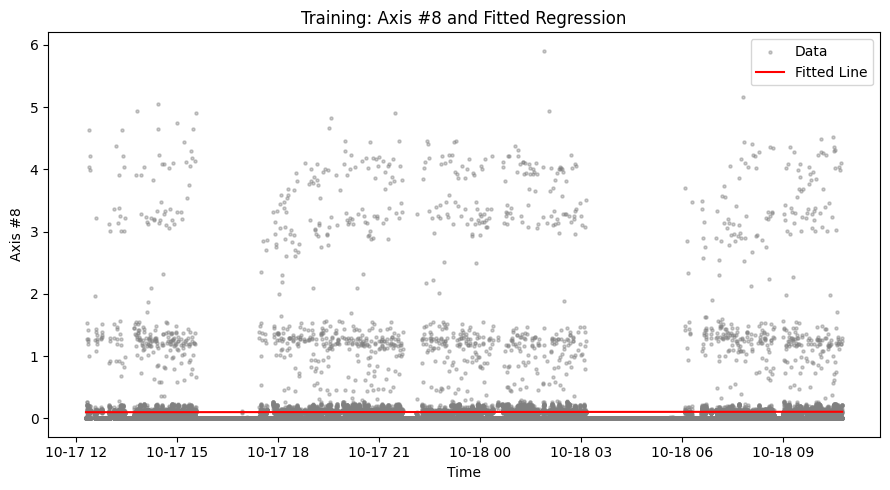

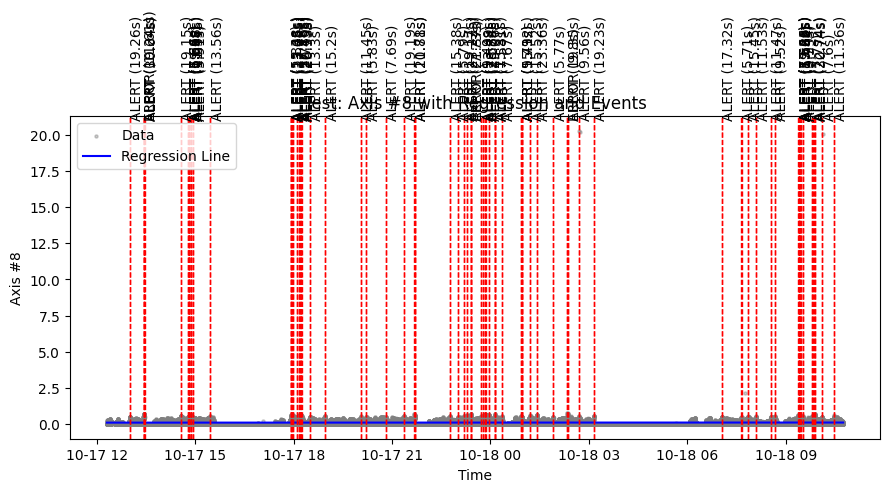

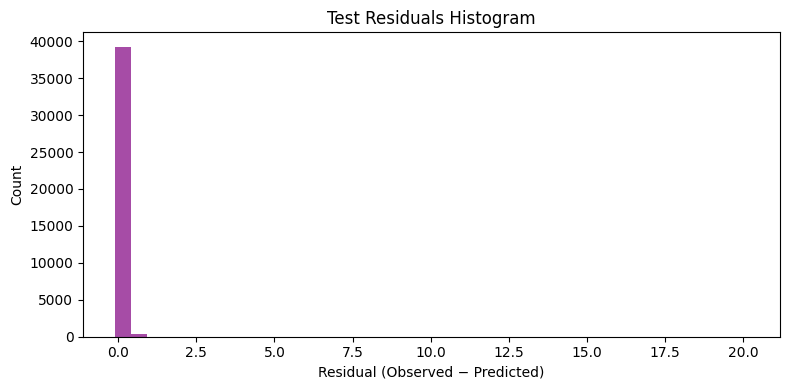

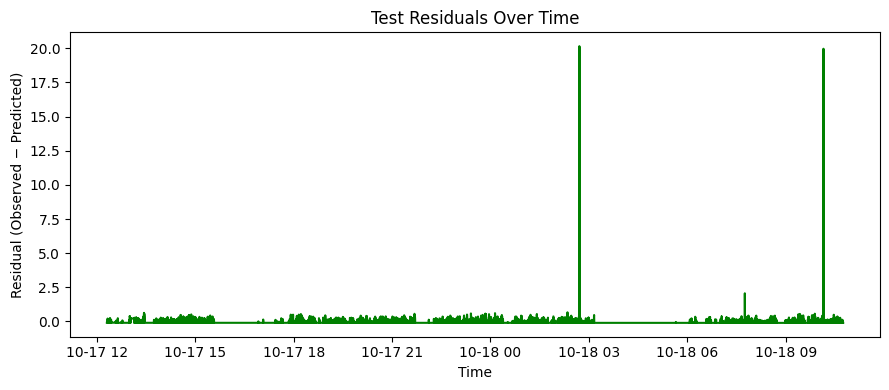

Updated events saved to logs/axis_events.csv


In [29]:
axis_name = 'Axis #8'

train_axis_with_time_df = load_axis_with_time(df_train, axis_name)
test_axis_with_time_df = load_axis_with_time(df_test, axis_name)


print('Train ' + axis_name + ' rows:', len(train_axis_with_time_df), ' Test rows:', len(test_axis1_with_time_df), '\n')
print('Train ' + axis_name + ' time range:', train_axis_with_time_df['Time'].min(), '→', train_axis_with_time_df['Time'].max())
print('Test ' + axis_name + ' time range:', test_axis1_with_time_df['Time'].min(),  '→', test_axis1_with_time_df['Time'].max())


train = train_axis_with_time_df.copy()
test  = test_axis_with_time_df.copy()

X_train = train[['t_sec']].values
y_train = train[axis_name].values

model = LinearRegression()
model.fit(X_train, y_train)

slope = float(model.coef_[0])
intercept = float(model.intercept_)
print('Slope:', slope)
print('Intercept:', intercept)

# Train residuals (for threshold derivation)
train['y_pred'] = model.predict(train[['t_sec']].values)
train['residual'] = train[axis_name] - train['y_pred']
train_pos = train[train['residual'] > 0].copy()

# Test residuals (for detection)
test['y_pred'] = model.predict(test[['t_sec']].values)
test['residual'] = test[axis_name] - test['y_pred']
test_pos = test[test['residual'] > 0].copy()

print('Train positive residuals:', len(train_pos), 'of', len(train))
print('Test  positive residuals:', len(test_pos),  'of', len(test))

train_pos_vals = train_pos['residual'].values

if len(train_pos_vals) == 0:
    # Fallback if no positive residuals in training
    minC_q = maxC_q = 0.0
    q_stats = (0, 0, 0)
    minC_s = maxC_s = 0.0
    s_stats = (0, 0)
else:
    minC_q, maxC_q, q_stats = threshold_quartile(train_pos_vals)
    minC_s, maxC_s, s_stats = threshold_std(train_pos_vals)

print('Quartile-based thresholds:')
print('  MinC_q =', minC_q, ' MaxC_q =', maxC_q, ' [q1, q3, IQR]=', q_stats)
print('Std-based thresholds:')
print('  MinC_s =', minC_s, ' MaxC_s =', maxC_s, ' [mean, std]=', s_stats)

# Choose which thresholds to use for detection
MinC = float(minC_q)
MaxC = float(maxC_q)
print('\nUsing quartile-based thresholds by default: MinC=', MinC, ' MaxC=', MaxC)

train_runs = detect_runs_above_threshold(train, MinC, grace_sec=2.0)
durations = [r['duration_sec'] for r in train_runs]
if len(durations) == 0:
    T = 2.0
else:
    T = max(2.0, float(np.percentile(durations, 95)))
    

print('Estimated T (sec):', T)


# Median dt from ALL training timestamps (sorted)
t_train = (train['Time'].astype('int64') // 10**9).values.astype(float)
dt_all = np.diff(t_train) if len(t_train) >= 2 else np.array([2.0])
median_dt = float(np.median(dt_all)) if len(dt_all) else 2.0

# Choose how many consecutive samples you require above threshold
N = 2  # we will try 2 first. we can raise to 5–10 for stricter persistence

# Final persistence time
T = max(2.0, N * median_dt)
print("Estimated T (sec):", T)



alerts, errors = detect_events(test, MinC, MaxC, T, grace_sec=2.0)
events_df = pd.DataFrame(alerts + errors, columns=[
    'event_id','level','start_time','end_time','duration_sec','peak_residual','mean_residual','area_above_baseline'
])


# prepend a column to events_df
events_df.insert(0, 'axis', axis_name)

print('Detected events:')
display(events_df.head(20))
print('Total Alerts:', len(alerts), ' Total Errors:', len(errors))


# 1) Training scatter and fitted line
plt.figure(figsize=(9,5))
plt.scatter(train['Time'], train[axis_name], s=5, alpha=0.4)
plt.plot(train['Time'], train['y_pred'], color='red', linewidth=2)
plt.title('Training: '+ axis_name +' and Fitted Regression')
plt.xlabel('Time')
plt.ylabel(axis_name)
plt.tight_layout()
plt.show()


# 2) Test scatter, regression line, and event markers with duration annotations
plt.figure(figsize=(9,5))
plt.scatter(test['Time'], test[axis_name], s=5, alpha=0.4)
plt.plot(test['Time'], test['y_pred'], color='red', linewidth=2)
plt.title('Test: ' + axis_name + ' with Regression and Events')
plt.xlabel('Time')
plt.ylabel(axis_name)

y_top = max(float(test[axis_name].max()), float(test['y_pred'].max()))
for ev in alerts + errors:
    plt.axvline(ev['start_time'], linewidth=1, color='green' if ev['level'] == 'ALERT' else 'red')
    plt.axvline(ev['end_time'], linewidth=1)
    dur = round(ev['duration_sec'], 2)
    plt.annotate(f"{ev['level']} ({dur}s)", xy=(ev['start_time'], y_top), xytext=(0, 10), textcoords='offset points', rotation=90)

plt.tight_layout()
plt.show()


# 3) Residual histogram (test)
plt.figure(figsize=(8,4))
plt.hist(test['residual'], bins=40)
plt.title('Test Residuals Histogram')
plt.xlabel('Residual (Observed − Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 4) Residual over time (test)
plt.figure(figsize=(9,4))
plt.plot(test['Time'], test['residual'])
plt.title('Test Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Observed − Predicted)')
plt.tight_layout()
plt.show()



# 1) Training scatter and fitted line
plt.figure(figsize=(9,5))
plt.scatter(train['Time'], train[axis_name], s=5, alpha=0.4, color='gray', label='Data')
plt.plot(train['Time'], train['y_pred'], color='red', label='Fitted Line')
plt.title('Training: '+ axis_name +' and Fitted Regression')
plt.xlabel('Time')
plt.ylabel(axis_name)
plt.legend()
plt.tight_layout()
plt.show()


# 2) Test scatter, regression line, and event markers with duration annotations
plt.figure(figsize=(9,5))
plt.scatter(test['Time'], test[axis_name], s=5, alpha=0.4, color='gray', label='Data')
plt.plot(test['Time'], test['y_pred'], color='blue', label='Regression Line')
plt.title('Test: ' + axis_name + ' with Regression and Events')
plt.xlabel('Time')
plt.ylabel(axis_name)

y_top = max(float(test[axis_name].max()), float(test['y_pred'].max()))
for ev in alerts + errors:
    if ev['level'] == 'alert':
        line_color = 'orange'
    else:
        line_color = 'red'
    plt.axvline(ev['start_time'], linewidth=1, color=line_color, linestyle='--')
    plt.axvline(ev['end_time'], linewidth=1, color=line_color, linestyle='--')
    dur = round(ev['duration_sec'], 2)
    plt.annotate(f"{ev['level']} ({dur}s)", xy=(ev['start_time'], y_top), 
                 xytext=(0, 10), textcoords='offset points', rotation=90)

plt.legend()
plt.tight_layout()
plt.show()

# 3) Residual histogram (test)
plt.figure(figsize=(8,4))
plt.hist(test['residual'], bins=40, color='purple', alpha=0.7)
plt.title('Test Residuals Histogram')
plt.xlabel('Residual (Observed − Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# 4) Residual over time (test)
plt.figure(figsize=(9,4))
plt.plot(test['Time'], test['residual'], color='green')
plt.title('Test Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Observed − Predicted)')
plt.tight_layout()
plt.show()


# load the events CSV file and append the values of events_df to it
existing_events_df = pd.read_csv(EVENTS_CSV)
combined_events_df = pd.concat([existing_events_df, events_df], ignore_index=True)
combined_events_df.to_csv(EVENTS_CSV, index=False)
print('Updated events saved to', EVENTS_CSV)